# MAPS

Outline of Madrid and Neighbourhoods: https://code.earthengine.google.com/98a5e619e151e1b5a5fe53347bdcb41a

Nighttime LST: https://code.earthengine.google.com/0de47b11b04655ce6034564ee7a2c99e

Daytime LST: https://code.earthengine.google.com/d920f219794f13551a50e008e3a9b597

Dynamic World: https://code.earthengine.google.com/c0cf85c57462f8cee6670d4b67cc459a

NDVI levels: https://code.earthengine.google.com/ac485d944b491873e90aa7681d940040

UHI effect (subneighbourhoods): https://code.earthengine.google.com/a3125258ef9a0144559ccc3702025df0

# Setup

## Install packages

In [ ]:
!pip install geemap
!pip install earthengine-api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.1 MB/s eta 0:00:00


## Load libraries

In [ ]:
import ee
import geemap
import pandas as pd
import numpy as np
from datetime import datetime
from geopy.point import Point
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
import statsmodels.api as sm

## Initialize GEE

In [ ]:
ee.Authenticate()

# Initialize the Earth Engine API
ee.Initialize(project='ee-lvillaxieu2020')

## Load data

In [ ]:
# Load datasets
landsat_5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filterDate('1984-01-01', '2012-05-05') \
    .filter(ee.Filter.lt('CLOUD_COVER', 20))

landsat_7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filterDate('1999-01-01', '2021-12-31') \
    .filter(ee.Filter.lt('CLOUD_COVER', 20))

landsat_8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2018-06-01', '2024-08-31') \
    .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
    .median()

landsat_9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
    .filterDate('2021-06-01', '2024-08-31') \
    .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
    .median()

modis_lst = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filter(ee.Filter.calendarRange(6, 8, 'month')) \
    .mean()

modis_ndvi = ee.ImageCollection('MODIS/061/MOD13A1') \
    .filter(ee.Filter.calendarRange(6, 8, 'month')) \
    .mean()

# Load Sentinel-2 Harmonized for NDVI Analysis (2018-2024)
sentinel_2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate('2024-06-01', '2024-08-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .median()

# Custom Feature Collections
madrid_urban = ee.FeatureCollection("projects/ee-lvillaxieu2020/assets/mad")
madrid_region = ee.FeatureCollection("projects/ee-lvillaxieu2020/assets/municipality_madrid")
neighborhoods = ee.FeatureCollection("projects/ee-lvillaxieu2020/assets/Barrios")

selected_districts = [
    "Vicálvaro", "San Blas - Canillejas", "Villa de Vallecas",
    "Villaverde", "Puente de Vallecas", "Moratalaz",
    "Latina", "Carabanchel", "Usera"
]

selected_districts_fc = neighborhoods.filter(ee.Filter.inList("NOMDIS", selected_districts))

## To load csv files for socioeconomic data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Complete_SocioEconomic.csv to Complete_SocioEconomic.csv
Saving Vulnerability_Index.csv to Vulnerability_Index.csv


## Preprocessing: Conversion Functions

In [ ]:
def scale_thermal_bands(image, collection_name):
    """ Scale Landsat & MODIS thermal bands dynamically, with fallback values if metadata is missing """
    band_names = image.bandNames().getInfo()
    print(f"Available bands in {collection_name}: {band_names}")

    if 'LST_Night_1km' in band_names:
        return image.select(['LST_Night_1km']).multiply(0.02).subtract(273.15).rename('LST_Celsius')

    if 'ST_B10' in band_names:  # Landsat 8 & 9
        gain = ee.Algorithms.If(image.get('TEMPERATURE_MULT_BAND_ST_B10'), image.get('TEMPERATURE_MULT_BAND_ST_B10'), 0.00341802)
        offset = ee.Algorithms.If(image.get('TEMPERATURE_ADD_BAND_ST_B10'), image.get('TEMPERATURE_ADD_BAND_ST_B10'), 149.0)
        return image.select('ST_B10').multiply(ee.Number(gain)).add(ee.Number(offset)).subtract(273.15).rename('LST_Celsius')

    if 'ST_B6' in band_names:  # Landsat 5
        gain = ee.Algorithms.If(image.get('TEMPERATURE_MULT_BAND_ST_B6'), image.get('TEMPERATURE_MULT_BAND_ST_B6'), 0.05518)
        offset = ee.Algorithms.If(image.get('TEMPERATURE_ADD_BAND_ST_B6'), image.get('TEMPERATURE_ADD_BAND_ST_B6'), 1.2378)
        return image.select('ST_B6').multiply(ee.Number(gain)).add(ee.Number(offset)).subtract(273.15).rename('LST_Celsius')

    print(f"Warning: No thermal bands found in {collection_name}")
    return image

def scale_ndvi(image, collection_name):
    """
    Scale NDVI from different sources
    - MODIS: Multiply by 0.0001
    - Sentinel-2: Calculate NDVI using red and NIR bands
    """
    band_names = image.bandNames().getInfo()
    print(f"Available bands in {collection_name}: {band_names}")

    if 'NDVI' in band_names:
        return image.select('NDVI').multiply(0.0001).rename('NDVI')

    # Sentinel-2 NDVI calculation
    if collection_name == 'COPERNICUS/S2_HARMONIZED':
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return ndvi

    print(f"Warning: NDVI band not found in {collection_name}")
    return image

# EDA

In [ ]:
landsat_8_lst = scale_thermal_bands(landsat_8, 'LANDSAT/LC08/C02/T1_L2')
landsat_9_lst = scale_thermal_bands(landsat_9, 'LANDSAT/LC09/C02/T1_L2')
modis_lst = scale_thermal_bands(modis_lst, 'MODIS/061/MOD11A1')
modis_ndvi = scale_ndvi(modis_ndvi, 'MODIS/061/MOD13A1')
sentinel_2_ndvi = scale_ndvi(sentinel_2, 'COPERNICUS/S2_HARMONIZED')

# ===== REGION ANALYSIS =====
def safe_reduce_region(image, region, scale=500):
    """ Safely reduce an image over a region, handling empty images. """
    try:
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean().combine(
                reducer2=ee.Reducer.minMax(),
                sharedInputs=True
            ),
            geometry=region.geometry(),
            scale=scale,
            bestEffort=True,
            maxPixels=1e9
        ).getInfo()

        if not stats or all(v is None for v in stats.values()):  # If stats is empty or all values are None
            return {"Warning": "No valid data found in this region"}

        return stats

    except Exception as e:
        return {"Error": str(e)}

# Compute statistics
landsat_8_lst_stats = safe_reduce_region(landsat_8_lst, madrid_region, scale=500)
landsat_9_lst_stats = safe_reduce_region(landsat_9_lst, madrid_region, scale=500)
modis_lst_stats = safe_reduce_region(modis_lst, madrid_region, scale=1000)
modis_ndvi_stats = safe_reduce_region(modis_ndvi, madrid_region, scale=1000)
sentinel_2_ndvi_stats = safe_reduce_region(sentinel_2_ndvi, madrid_region, scale=500)

# Print results with safety checks
print("\nLandsat 8 LST Statistics (°C):", landsat_8_lst_stats)
print("\nLandsat 9 LST Statistics (°C):", landsat_9_lst_stats)
print("\nMODIS LST Statistics (°C):", modis_lst_stats)
print("\nMODIS NDVI Statistics:", modis_ndvi_stats)
print("\nSentinel-2 NDVI Statistics:", sentinel_2_ndvi_stats)

Available bands in LANDSAT/LC08/C02/T1_L2: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']
Available bands in LANDSAT/LC09/C02/T1_L2: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']
Available bands in MODIS/061/MOD11A1: ['LST_Celsius']
Available bands in MODIS/061/MOD13A1: ['NDVI']
Available bands in COPERNICUS/S2_HARMONIZED: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']

Landsat 8 LST Statistics (°C): {'LST_Celsius_max': 48.48222713000001, 'LST_Celsius_mean': 32.53780920700633, 'LST_Celsius_min': 10.810519699999986}

Landsat 9 LST Statistics (°C): {'LST_C

## Plots

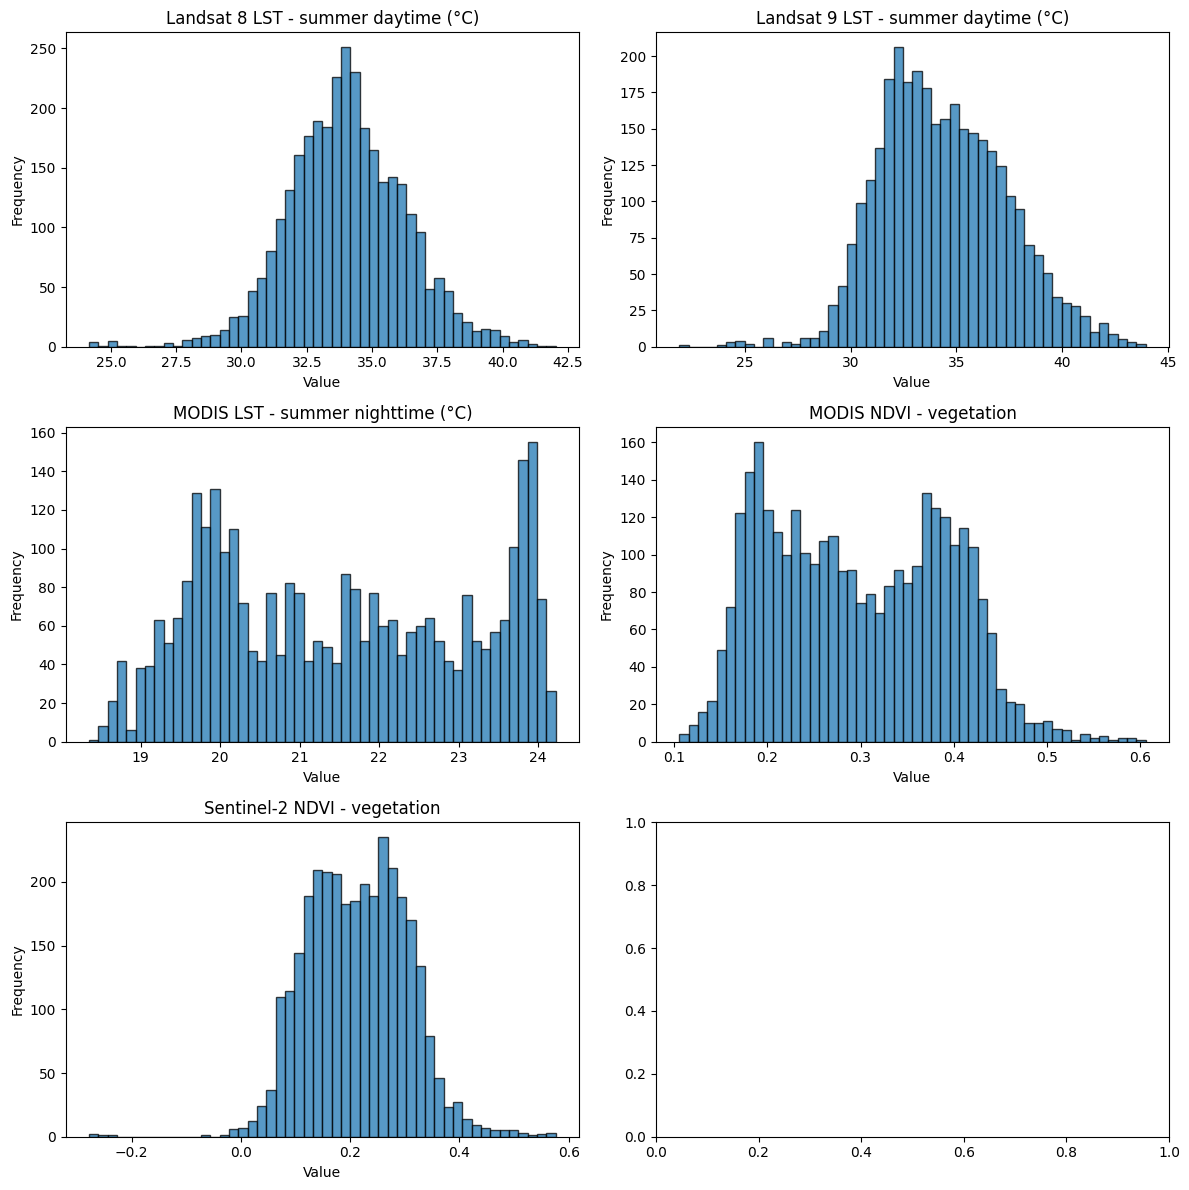

In [ ]:
def extract_values(image, region, scale=500):
    """Extracts pixel values over a region for histogram plotting"""
    try:
        pixels = image.reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=region.geometry(),
            scale=scale,
            bestEffort=True,
            maxPixels=1e9
        ).getInfo()

        values = pixels[list(pixels.keys())[0]]  # Extract values from first available band
        return np.array(values) if values else np.array([])

    except Exception as e:
        print(f"Error extracting values: {e}")
        return np.array([])

# Extract pixel values for distributions
landsat_8_values = extract_values(landsat_8_lst, madrid_urban)
landsat_9_values = extract_values(landsat_9_lst, madrid_urban)
modis_lst_values = extract_values(modis_lst, madrid_urban)
modis_ndvi_values = extract_values(modis_ndvi, madrid_urban)
sentinel_2_ndvi_values = extract_values(sentinel_2_ndvi, madrid_urban)

# Plot Distributions
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Create a 3x2 subplot grid

datasets = [
    (landsat_8_values, "Landsat 8 LST - summer daytime (°C)", axes[0, 0]),
    (landsat_9_values, "Landsat 9 LST - summer daytime (°C)", axes[0, 1]),
    (modis_lst_values, "MODIS LST - summer nighttime (°C)", axes[1, 0]),
    (modis_ndvi_values, "MODIS NDVI - vegetation", axes[1, 1]),
    (sentinel_2_ndvi_values, "Sentinel-2 NDVI - vegetation", axes[2, 0])
]

for values, title, ax in datasets:
    if values.size > 0:
        ax.hist(values, bins=50, alpha=0.75, edgecolor='black')
        ax.set_title(title)
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
    else:
        ax.text(0.5, 0.5, "No Data Available", ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

# NDVI

## Historical Evolution

In [ ]:
# Years you want
years = list(range(2000, 2025))  # 2000 to 2024

# Function to compute Landsat NDVI
def compute_landsat_ndvi(year):
    if year < 2013:
        landsat_collection = 'LANDSAT/LT05/C02/T1_L2'  # Landsat 5
        nir_band, red_band = 'SR_B4', 'SR_B3'
    else:
        landsat_collection = 'LANDSAT/LC08/C02/T1_L2'  # Landsat 8
        nir_band, red_band = 'SR_B5', 'SR_B4'

    # Load Landsat collection (summer months)
    landsat_ndvi = ee.ImageCollection(landsat_collection) \
        .filterDate(f'{year}-06-01', f'{year}-08-31') \
        .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
        .map(lambda img: img.normalizedDifference([nir_band, red_band]).rename('NDVI'))

    return landsat_ndvi.median()

# List to store NDVI mean values
ndvi_mean_list = []

# Loop through years
for year in years:
    print(f"Processing Landsat NDVI for year {year}...")

    try:
        ndvi_image = compute_landsat_ndvi(year)

        ndvi_mean = ndvi_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=madrid_urban.geometry(),
            scale=30,
            maxPixels=1e9
        ).get('NDVI').getInfo()

        ndvi_mean_list.append(ndvi_mean)

    except Exception as e:
        print(f"⚠️ Warning: No NDVI data for {year}. Appending None.")
        ndvi_mean_list.append(None)

# Create DataFrame
df_ndvi_urban = pd.DataFrame({
    'year': years,
    'NDVI_mean': ndvi_mean_list
})

# Interpolate missing NDVI values (linear interpolation between years)
df_ndvi_urban['NDVI_mean'] = df_ndvi_urban['NDVI_mean'].interpolate(method='linear')

# Print the final table
print("\n=== NDVI Mean for Madrid Urban Area (2000–2024) ===")
print(df_ndvi_urban.to_string(index=False))

Processing Landsat NDVI for year 2000...
Processing Landsat NDVI for year 2001...
Processing Landsat NDVI for year 2002...
Processing Landsat NDVI for year 2003...
Processing Landsat NDVI for year 2004...
Processing Landsat NDVI for year 2005...
Processing Landsat NDVI for year 2006...
Processing Landsat NDVI for year 2007...
Processing Landsat NDVI for year 2008...
Processing Landsat NDVI for year 2009...
Processing Landsat NDVI for year 2010...
Processing Landsat NDVI for year 2011...
Processing Landsat NDVI for year 2012...
⚠️ Warning: No NDVI data for 2012. Appending None.
Processing Landsat NDVI for year 2013...
Processing Landsat NDVI for year 2014...
Processing Landsat NDVI for year 2015...
Processing Landsat NDVI for year 2016...
Processing Landsat NDVI for year 2017...
Processing Landsat NDVI for year 2018...
Processing Landsat NDVI for year 2019...
Processing Landsat NDVI for year 2020...
Processing Landsat NDVI for year 2021...
Processing Landsat NDVI for year 2022...
Proces

## Region & Urban Anlaysis

In [ ]:
# Compute NDVI directly on the median composite Sentinel-2 image
mean_ndvi_s2_2024 = sentinel_2.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Define geometries
madrid_region_geom = madrid_region.geometry()  # Entire Madrid region
madrid_city_geom = madrid_urban.geometry()  # City of Madrid

# Compute NDVI for each area
ndvi_areas = {
    "Madrid Region": madrid_region_geom,
    "Madrid City": madrid_city_geom,
    "Area of Interest (Selected 9 Districts)": neighborhoods.filter(ee.Filter.inList("NOMDIS", selected_districts))
}

ndvi_results = []
for area_name, geom in ndvi_areas.items():
    ndvi_value = mean_ndvi_s2_2024.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=100,  # Increased scale to reduce memory usage
        maxPixels=1e7  # Reduce maxPixels
    ).getInfo()

    ndvi = ndvi_value.get('NDVI', None)
    ndvi_results.append({'Area': area_name, 'NDVI': ndvi})

# Convert results to DataFrame and print
df_ndvi_madrid_2024 = pd.DataFrame(ndvi_results)

print("\nSentinel-2 NDVI for Madrid Region & Madrid Urban (2024 Summer):")
print(df_ndvi_madrid_2024.sort_values("NDVI", ascending=True))


Sentinel-2 NDVI for Madrid Region & Madrid Urban (2024 Summer):
                                      Area      NDVI
2  Area of Interest (Selected 9 Districts)  0.159533
1                              Madrid City  0.214255
0                            Madrid Region  0.274444


## Neighbourhood analysis

In [ ]:
# Initialize an empty list to store the results for all neighborhoods
ndvi_results = []

# Iterate over all neighborhoods
for neighborhood in neighborhoods.toList(neighborhoods.size()).getInfo():
    district_name = neighborhood['properties']['NOMDIS']  # Get the name of the neighborhood (district)

    # Get the geometry of the neighborhood
    neighborhood_geom = ee.Geometry(neighborhood['geometry'])

    # Compute NDVI for the neighborhood
    ndvi_value = mean_ndvi_s2_2024.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=neighborhood_geom,
        scale=30,  # Slightly increased scale (30m instead of 10m)
        maxPixels=1e7  # Reduce maxPixels
    ).getInfo()

    # Get the NDVI value and handle potential None result
    ndvi = ndvi_value.get('NDVI', None)
    if ndvi is not None:
        # Append the results, including the neighborhood name and its NDVI
        ndvi_results.append({'Neighborhood': district_name, 'NDVI': ndvi})

# Convert results to DataFrame
df_ndvi_neighborhoods = pd.DataFrame(ndvi_results)

# Group by Neighborhood and calculate the median NDVI for each
df_median_ndvi = df_ndvi_neighborhoods.groupby('Neighborhood')['NDVI'].median().reset_index()

# Sort by median NDVI from lowest to highest
df_median_ndvi_sorted = df_median_ndvi.sort_values("NDVI", ascending=True)

# Print the sorted results by median NDVI
print("\nSentinel-2 Median NDVI for All Neighborhoods:")
print(df_median_ndvi_sorted)


Sentinel-2 Median NDVI for All Neighborhoods:
             Neighborhood      NDVI
3                  Centro  0.110539
5                Chamberí  0.117085
19      Villa de Vallecas  0.129822
16                 Tetuán  0.138154
14              Salamanca  0.143228
18              Vicálvaro  0.152410
1                 Barajas  0.167649
20             Villaverde  0.171275
15  San Blas - Canillejas  0.172022
2             Carabanchel  0.176563
13                 Retiro  0.177442
0              Arganzuela  0.181431
4               Chamartín  0.189814
12     Puente de Vallecas  0.193167
6           Ciudad Lineal  0.193720
17                  Usera  0.203965
8               Hortaleza  0.213522
9                  Latina  0.218731
7   Fuencarral - El Pardo  0.233677
11              Moratalaz  0.240514
10      Moncloa - Aravaca  0.276140


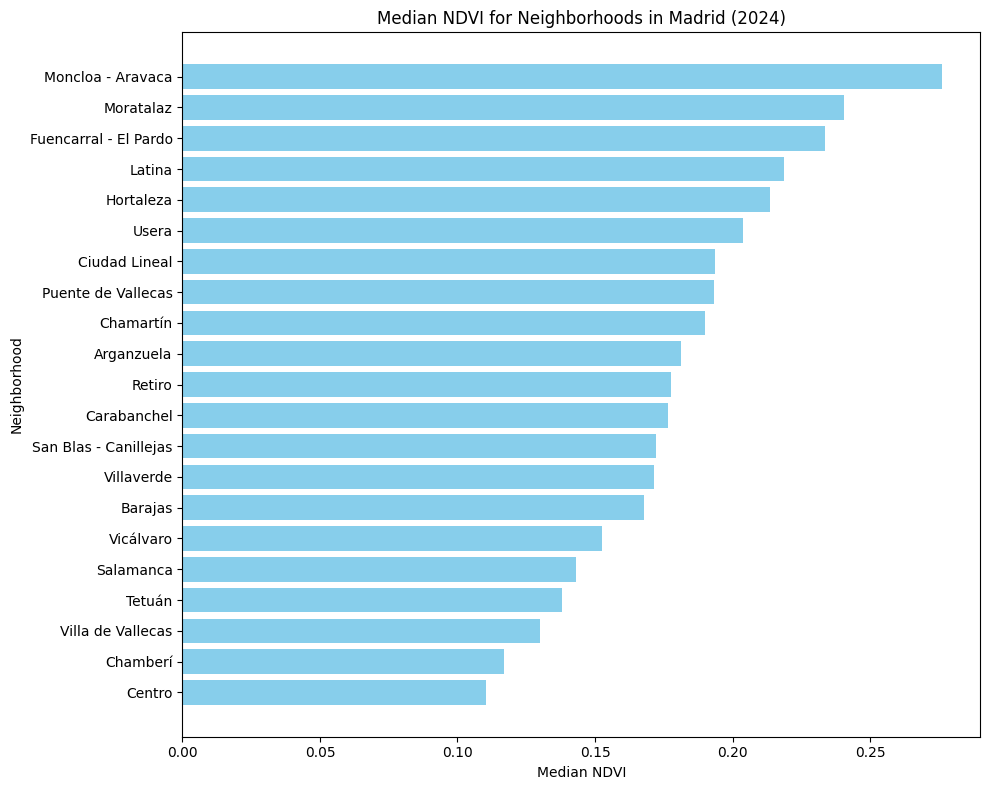

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(df_median_ndvi_sorted['Neighborhood'], df_median_ndvi_sorted['NDVI'], color='skyblue')
plt.xlabel('Median NDVI')
plt.ylabel('Neighborhood')
plt.title('Median NDVI for Neighborhoods in Madrid (2024)')
plt.tight_layout()
plt.show()

## Subneighbourhood Analysis

In [ ]:
# Initialize an empty list to store the results for all neighborhoods
ndvi_results = []

# Iterate over all neighborhoods
for neighborhood in neighborhoods.toList(neighborhoods.size()).getInfo():
    district_name = neighborhood['properties']['NOMDIS']  # Get the name of the neighborhood (district)
    subneighborhood_name = neighborhood['properties']['NOMBRE']  # Get the name of the sub-neighborhood

    # Get the geometry of the neighborhood
    neighborhood_geom = ee.Geometry(neighborhood['geometry'])

    # Compute NDVI for the neighborhood
    ndvi_value = mean_ndvi_s2_2024.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=neighborhood_geom,
        scale=30,  # Slightly increased scale (30m instead of 10m)
        maxPixels=1e7  # Reduce maxPixels
    ).getInfo()

    # Get the NDVI value and handle potential None result
    ndvi = ndvi_value.get('NDVI', None)
    if ndvi is not None:
        # Append the results, including sub-neighborhood name
        ndvi_results.append({'Neighborhood': district_name, 'Subneighborhood': subneighborhood_name, 'NDVI': ndvi})

# Convert results to DataFrame and sort by NDVI
df_ndvi_neighborhoods = pd.DataFrame(ndvi_results)

# Print the sorted results by NDVI
print("\nSentinel-2 NDVI for All Neighborhoods (Including Subneighborhoods):")
print(df_ndvi_neighborhoods.sort_values("NDVI", ascending=True))


Sentinel-2 NDVI for All Neighborhoods (Including Subneighborhoods):
             Neighborhood       Subneighborhood      NDVI
5                  Centro                   Sol  0.055927
36                 Tetuán            Berruguete  0.078531
20              Salamanca                  Goya  0.090372
80     Puente de Vallecas             San Diego  0.092655
37               Chamberí            Gaztambide  0.099002
..                    ...                   ...       ...
51      Moncloa - Aravaca         Casa de Campo  0.314043
56      Moncloa - Aravaca            El Plantío  0.316592
53      Moncloa - Aravaca  Ciudad Universitaria  0.341832
44  Fuencarral - El Pardo        Fuentelarreina  0.361363
17                 Retiro         Los Jerónimos  0.410108

[131 rows x 3 columns]


<ipython-input-14-524fabbe71fc>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['Color'] = top_10['Neighborhood'].map(neighborhood_color_map)
<ipython-input-14-524fabbe71fc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_10['Color'] = bottom_10['Neighborhood'].map(neighborhood_color_map)


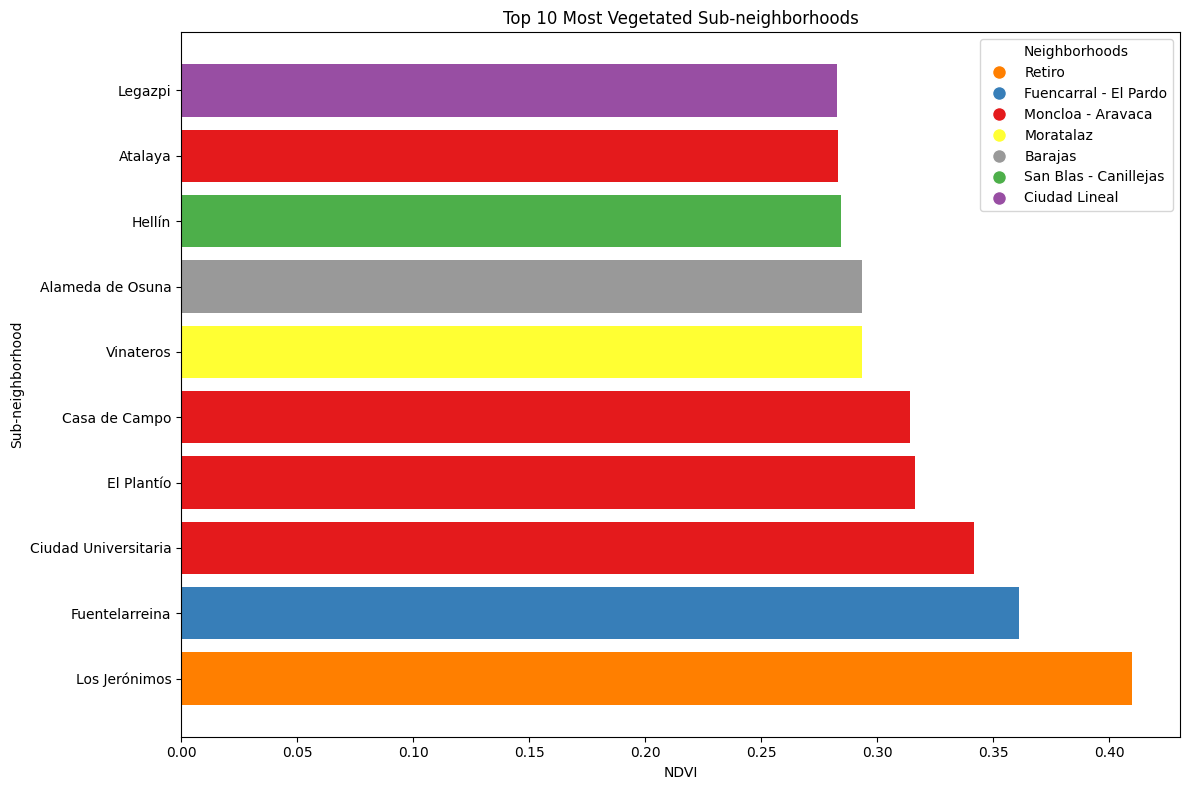

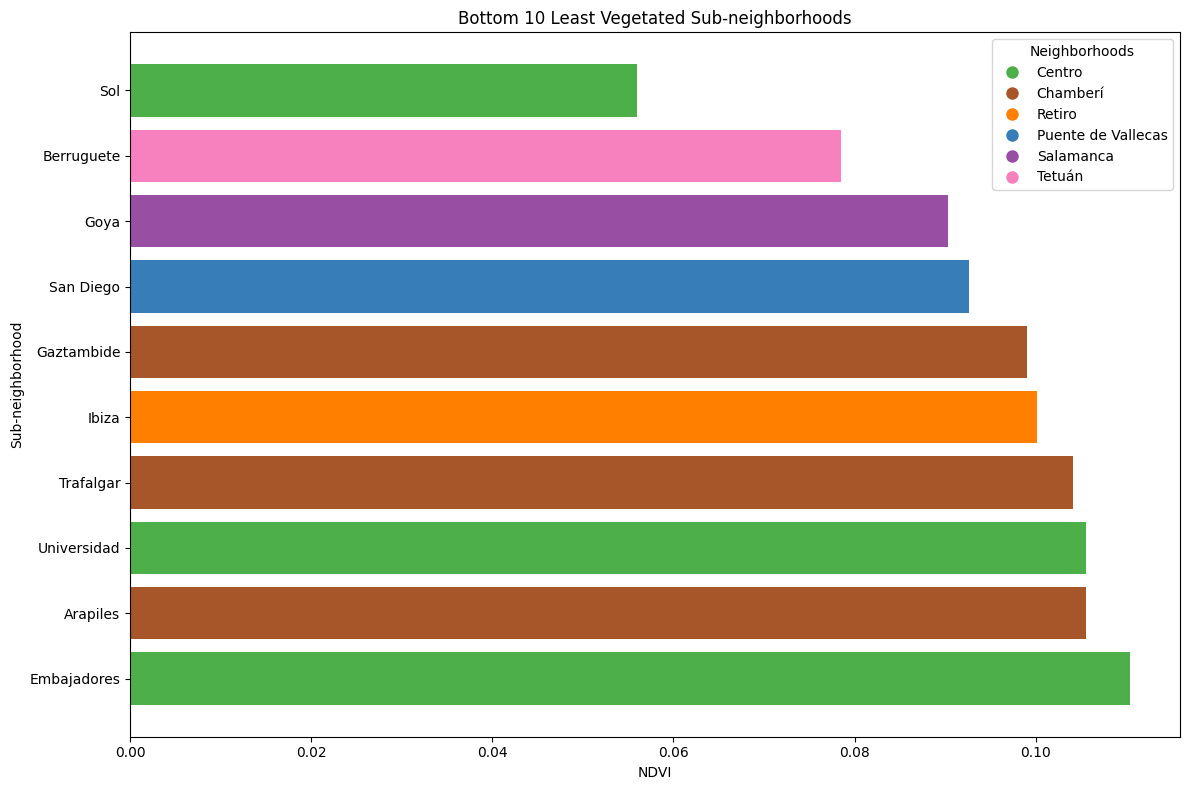

In [ ]:
# Sort by NDVI and get the top 10 most vegetated and bottom 10 least vegetated sub-neighborhoods
df_sorted = df_ndvi_neighborhoods.sort_values("NDVI", ascending=False)

# Get the top 10 and bottom 10 sub-neighborhoods
top_10 = df_sorted.head(10)
bottom_10 = df_sorted.tail(10)

# Create a color palette with one color for each unique neighborhood
unique_neighborhoods_top = top_10['Neighborhood'].unique()
unique_neighborhoods_bottom = bottom_10['Neighborhood'].unique()
unique_neighborhoods = list(set(unique_neighborhoods_top) | set(unique_neighborhoods_bottom))  # Union of both

# Using a set color palette for the unique neighborhoods
colors = sns.color_palette("Set1", len(unique_neighborhoods))

# Map each neighborhood to a unique color
neighborhood_color_map = {neighborhood: colors[i] for i, neighborhood in enumerate(unique_neighborhoods)}

# Assign colors to the top 10 sub-neighborhoods
top_10['Color'] = top_10['Neighborhood'].map(neighborhood_color_map)

# Assign colors to the bottom 10 sub-neighborhoods
bottom_10['Color'] = bottom_10['Neighborhood'].map(neighborhood_color_map)

# Plotting for the top 10 most vegetated sub-neighborhoods
plt.figure(figsize=(12, 8))
plt.barh(top_10['Subneighborhood'], top_10['NDVI'], color=top_10['Color'])
plt.xlabel('NDVI')
plt.ylabel('Sub-neighborhood')
plt.title('Top 10 Most Vegetated Sub-neighborhoods')

# Creating a legend for the neighborhoods
handles_top = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in top_10['Color'].unique()]
plt.legend(handles_top, top_10['Neighborhood'].unique(), title="Neighborhoods")

# Display the plot
plt.tight_layout()
plt.show()

# Plotting for the bottom 10 least vegetated sub-neighborhoods
plt.figure(figsize=(12, 8))
plt.barh(bottom_10['Subneighborhood'], bottom_10['NDVI'], color=bottom_10['Color'])
plt.xlabel('NDVI')
plt.ylabel('Sub-neighborhood')
plt.title('Bottom 10 Least Vegetated Sub-neighborhoods')

# Creating a legend for the neighborhoods
handles_bottom = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                  for color in bottom_10['Color'].unique()]
plt.legend(handles_bottom, bottom_10['Neighborhood'].unique(), title="Neighborhoods")

# Display the plot
plt.tight_layout()
plt.show()

# LST

In [ ]:
# ===== MERGE LANDSAT DATASETS =====
landsat_merged_lst = landsat_8_lst.add(landsat_9_lst).divide(2)

## Historical evolution of LST

In [ ]:
# Load MODIS Nighttime Land Surface Temperature
modis_lst = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filterDate('2000-01-01', '2024-12-31') \
    .filter(ee.Filter.calendarRange(6, 8, 'month'))  # Only summer months

In [ ]:
def scale_modis_lst(image):
    lst_celsius = image.select('LST_Night_1km').multiply(0.02).subtract(273.15).rename('LST_Celsius')
    return lst_celsius.copyProperties(image, image.propertyNames())

modis_lst_scaled = modis_lst.map(scale_modis_lst)

In [ ]:
# List of years
years = list(range(2000, 2025))

# Function to get mean summer LST per year
def year_reducer(year):
    filtered = modis_lst_scaled.filter(ee.Filter.calendarRange(year, year, 'year'))
    mean_image = filtered.mean().set('year', year).set('system:time_start', ee.Date.fromYMD(year, 7, 1).millis())
    return mean_image

# Build a collection of yearly mean images
yearly_lst = ee.ImageCollection.fromImages([year_reducer(y) for y in years])

In [ ]:
# Reduce to mean LST over Madrid Urban Area for each year
def extract_mean(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=madrid_urban.geometry(),
        scale=1000,  # MODIS native resolution
        maxPixels=1e13
    )
    return ee.Feature(None, {
        'year': image.get('year'),
        'LST_Celsius': mean_dict.get('LST_Celsius')
    })

madrid_urban_fc = yearly_lst.map(extract_mean)

In [ ]:
# Extract 'year' and 'LST_Celsius' directly
years = madrid_urban_fc.aggregate_array('year').getInfo()
temps = madrid_urban_fc.aggregate_array('LST_Celsius').getInfo()

# Build pandas DataFrame manually
madrid_urban_df = pd.DataFrame({
    'year': years,
    'LST_Celsius': temps
})

# Sort by year
madrid_urban_df = madrid_urban_df.sort_values(by='year')

# Display
print(madrid_urban_df)

    year  LST_Celsius
0   2000    19.293330
1   2001    20.231182
2   2002    20.648595
3   2003    21.747281
4   2004    20.104089
5   2005    21.500240
6   2006    21.097512
7   2007    19.490393
8   2008    20.307918
9   2009    21.556117
10  2010    21.619174
11  2011    20.734634
12  2012    21.201197
13  2013    21.451609
14  2014    20.723249
15  2015    22.849443
16  2016    22.458901
17  2017    22.368582
18  2018    21.755757
19  2019    21.838375
20  2020    22.188237
21  2021    21.388213
22  2022    23.377702
23  2023    23.488381
24  2024    23.971861


In [ ]:
print(yearly_lst.size().getInfo())

25


In [ ]:
print(madrid_urban_fc.size().getInfo())

25


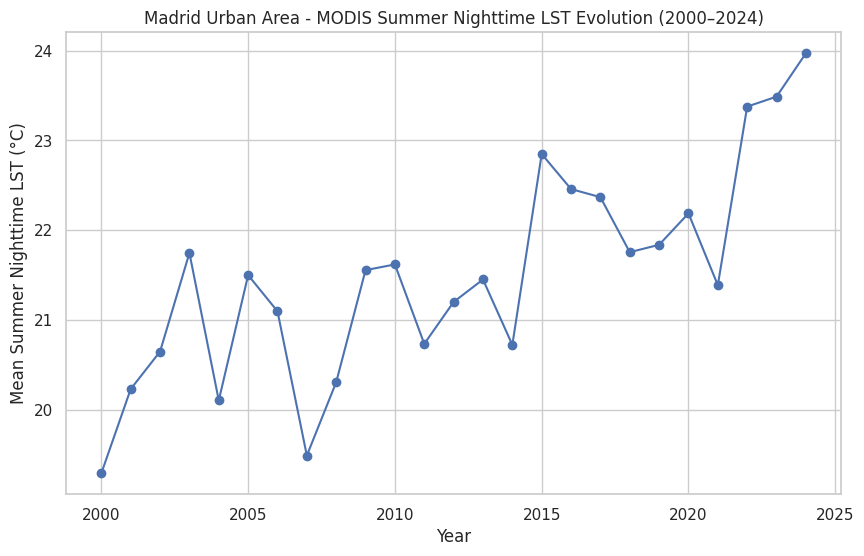

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(madrid_urban_df['year'], madrid_urban_df['LST_Celsius'], marker='o')
plt.xlabel('Year')
plt.ylabel('Mean Summer Nighttime LST (°C)')
plt.title('Madrid Urban Area - MODIS Summer Nighttime LST Evolution (2000–2024)')
plt.grid(True)
plt.show()

## Region & Urban Anlaysis

In [ ]:
def analyze_region_lst(image, region_fc, region_name, dataset_name):
    """
    Compute mean LST for Madrid Urban Area and Madrid Region.
    """
    print(f"Processing LST for {region_name} using {dataset_name}...")

    # Compute mean LST for the entire region
    lst_value = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region_fc.geometry(),
        scale=500,  # Adjust scale
        bestEffort=True,
        maxPixels=1e9
    ).get("LST_Celsius")

    try:
        lst_celsius = lst_value.getInfo()
    except:
        lst_celsius = None

    return {"Region": region_name, "Dataset": dataset_name, "Mean_LST_C": lst_celsius}


results = []
results.append(analyze_region_lst(landsat_merged_lst, madrid_urban, "Madrid Urban Area", "Landsat 8+9"))
results.append(analyze_region_lst(landsat_merged_lst, madrid_region, "Madrid Region", "Landsat 8+9"))
results.append(analyze_region_lst(modis_lst, madrid_urban, "Madrid Urban Area", "MODIS Nighttime"))
results.append(analyze_region_lst(modis_lst, madrid_region, "Madrid Region", "MODIS Nighttime"))

df_madrid_lst = pd.DataFrame(results).sort_values("Mean_LST_C", ascending=False)
print("\nMean LST for Madrid Regions:")
print(df_madrid_lst)

# Save Madrid Urban and Region LST data to CSV
df_madrid_lst.to_csv("madrid_lst_results.csv", index=False)

Processing LST for Madrid Urban Area using Landsat 8+9...
Processing LST for Madrid Region using Landsat 8+9...
Processing LST for Madrid Urban Area using MODIS Nighttime...
Processing LST for Madrid Region using MODIS Nighttime...

Mean LST for Madrid Regions:
              Region          Dataset  Mean_LST_C
0  Madrid Urban Area      Landsat 8+9   34.214479
1      Madrid Region      Landsat 8+9   32.734678
2  Madrid Urban Area  MODIS Nighttime   21.504070
3      Madrid Region  MODIS Nighttime   19.063887


## Neighbourhood Analysis

In [ ]:
# ===== PREPROCESS: Extract Unique Neighborhood & Sub-Neighborhood Mapping =====
# Get unique neighborhoods
neighborhood_list = neighborhoods.aggregate_array("NOMDIS").distinct().getInfo()

# Create a dictionary mapping each neighborhood to its sub-neighborhoods
neighborhood_to_sub = {}
for neighborhood in neighborhood_list:
    sub_neighborhoods = (
        neighborhoods.filter(ee.Filter.eq("NOMDIS", neighborhood))
        .aggregate_array("NOMBRE")
        .getInfo()
    )
    neighborhood_to_sub[neighborhood] = sub_neighborhoods

Processing LST for Centro using Landsat 8+9 (Daytime)...
Processing LST for Arganzuela using Landsat 8+9 (Daytime)...
Processing LST for Retiro using Landsat 8+9 (Daytime)...
Processing LST for Salamanca using Landsat 8+9 (Daytime)...
Processing LST for Chamartín using Landsat 8+9 (Daytime)...
Processing LST for Tetuán using Landsat 8+9 (Daytime)...
Processing LST for Chamberí using Landsat 8+9 (Daytime)...
Processing LST for Fuencarral - El Pardo using Landsat 8+9 (Daytime)...
Processing LST for Moncloa - Aravaca using Landsat 8+9 (Daytime)...
Processing LST for Latina using Landsat 8+9 (Daytime)...
Processing LST for Carabanchel using Landsat 8+9 (Daytime)...
Processing LST for Usera using Landsat 8+9 (Daytime)...
Processing LST for Puente de Vallecas using Landsat 8+9 (Daytime)...
Processing LST for Moratalaz using Landsat 8+9 (Daytime)...
Processing LST for Ciudad Lineal using Landsat 8+9 (Daytime)...
Processing LST for Hortaleza using Landsat 8+9 (Daytime)...
Processing LST for Vi

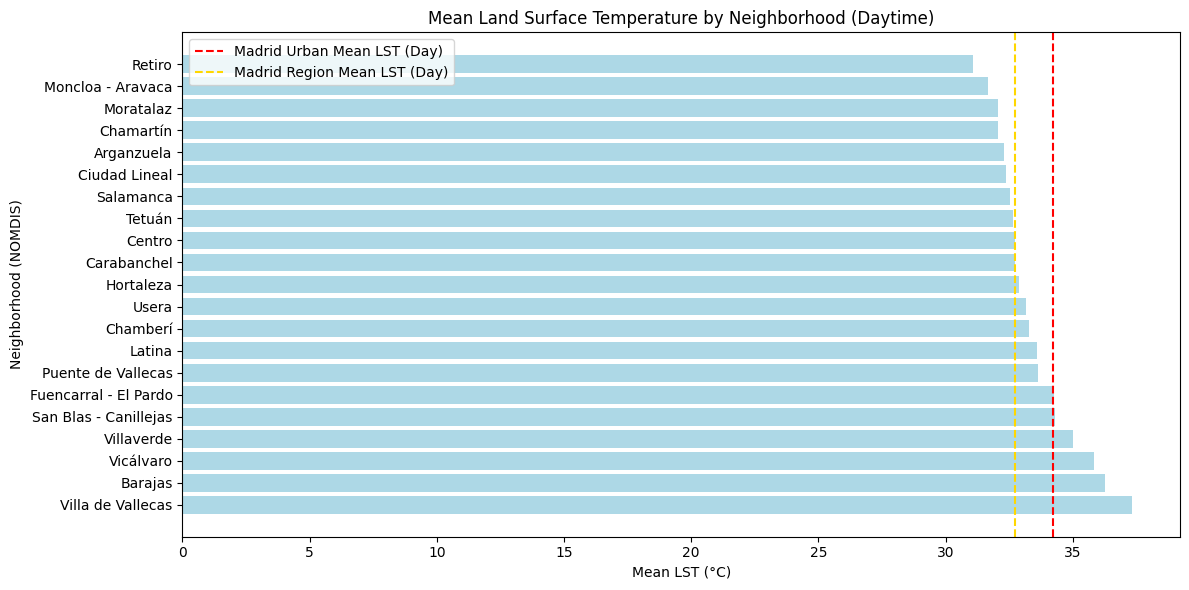

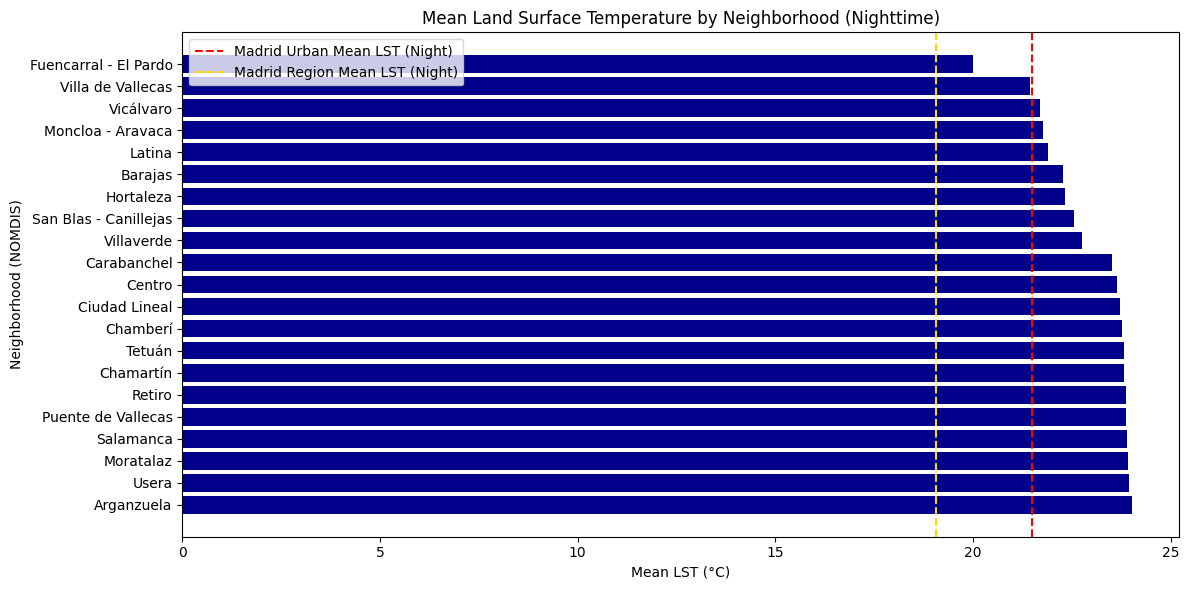


Urban vs Tree Cover LST Analysis (Daytime & Nighttime) Across Neighborhoods:
             Neighborhood          Dataset Time of Day  Mean LST (°C)
0                  Centro      Landsat 8+9     Daytime      32.713003
1              Arganzuela      Landsat 8+9     Daytime      32.279633
2                  Retiro      Landsat 8+9     Daytime      31.092954
3               Salamanca      Landsat 8+9     Daytime      32.511785
4               Chamartín      Landsat 8+9     Daytime      32.071532
5                  Tetuán      Landsat 8+9     Daytime      32.645377
6                Chamberí      Landsat 8+9     Daytime      33.294149
7   Fuencarral - El Pardo      Landsat 8+9     Daytime      34.247516
8       Moncloa - Aravaca      Landsat 8+9     Daytime      31.673793
9                  Latina      Landsat 8+9     Daytime      33.592156
10            Carabanchel      Landsat 8+9     Daytime      32.722074
11                  Usera      Landsat 8+9     Daytime      33.154010
12     Puent

In [ ]:
def analyze_lst_for_neighborhoods(image, dataset_name, time_of_day, neighborhoods_fc, df_madrid_lst):
    """
    Compute mean LST for each neighborhood (NOMDIS) in Madrid.
    """
    results = []

    neighborhood_list = neighborhoods_fc.aggregate_array("NOMDIS").distinct().getInfo()

    for neighborhood in neighborhood_list:
        print(f"Processing LST for {neighborhood} using {dataset_name} ({time_of_day})...")

        # Define neighborhood feature collection
        neighborhood_fc = neighborhoods_fc.filter(ee.Filter.eq("NOMDIS", neighborhood))

        # Ensure correct LST band is used
        if "LST_Celsius" not in image.bandNames().getInfo():
            lst_image = scale_thermal_bands(image, dataset_name).clip(neighborhood_fc)
        else:
            lst_image = image.clip(neighborhood_fc)

        # Compute mean LST for the neighborhood
        lst_stats = lst_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=neighborhood_fc.geometry(),
            scale=500 if "Landsat" in dataset_name else 1000,
            bestEffort=True,
            maxPixels=1e9
        )

        # Extract temperature values
        try:
            mean_lst = lst_stats.get("LST_Celsius").getInfo()
        except:
            mean_lst = None

        # Store results
        results.append({
            "Neighborhood": neighborhood,
            "Dataset": dataset_name,
            "Time of Day": time_of_day,
            "Mean LST (°C)": mean_lst
        })

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    return df_results

# Run LST analysis for neighborhoods during daytime (Landsat) and nighttime (MODIS)
df_neighborhoods_landsat_day = analyze_lst_for_neighborhoods(landsat_merged_lst, "Landsat 8+9", "Daytime", neighborhoods, df_madrid_lst)
df_neighborhoods_modis_night = analyze_lst_for_neighborhoods(modis_lst, "MODIS Nighttime", "Nighttime", neighborhoods, df_madrid_lst)

# Combine results
df_neighborhoods_combined = pd.concat([df_neighborhoods_landsat_day, df_neighborhoods_modis_night]).reset_index(drop=True)

# Extract reference LST values
urban_mean_lst_day = df_madrid_lst[df_madrid_lst['Region'] == 'Madrid Urban Area']['Mean_LST_C'].values[0]
regional_mean_lst_day = df_madrid_lst[df_madrid_lst['Region'] == 'Madrid Region']['Mean_LST_C'].values[0]
urman_mean_lst_night = df_madrid_lst[df_madrid_lst['Region'] == 'Madrid Urban Area']['Mean_LST_C'].values[1]
regional_mean_lst_night = df_madrid_lst[df_madrid_lst['Region'] == 'Madrid Region']['Mean_LST_C'].values[1]

# Plot barplot for daytime
plt.figure(figsize=(12, 6))
df_results_sorted = df_neighborhoods_landsat_day.sort_values("Mean LST (°C)", ascending=False)
plt.barh(df_results_sorted["Neighborhood"], df_results_sorted["Mean LST (°C)"], color='lightblue')

# Add mean LST lines for daytime
plt.axvline(urban_mean_lst_day, color="red", linestyle="--", label="Madrid Urban Mean LST (Day)")
plt.axvline(regional_mean_lst_day, color="gold", linestyle="--", label="Madrid Region Mean LST (Day)")

# Labels and title
plt.xlabel("Mean LST (°C)")
plt.ylabel("Neighborhood (NOMDIS)")
plt.title("Mean Land Surface Temperature by Neighborhood (Daytime)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot barplot for nighttime
plt.figure(figsize=(12, 6))
df_results_sorted = df_neighborhoods_modis_night.sort_values("Mean LST (°C)", ascending=False)
plt.barh(df_results_sorted["Neighborhood"], df_results_sorted["Mean LST (°C)"], color='darkblue')

# Add mean LST lines for nighttime
plt.axvline(urman_mean_lst_night, color="red", linestyle="--", label="Madrid Urban Mean LST (Night)")
plt.axvline(regional_mean_lst_night, color="gold", linestyle="--", label="Madrid Region Mean LST (Night)")

# Labels and title
plt.xlabel("Mean LST (°C)")
plt.ylabel("Neighborhood (NOMDIS)")
plt.title("Mean Land Surface Temperature by Neighborhood (Nighttime)")
plt.legend()
plt.tight_layout()
plt.show()

# Print results
print("\nUrban vs Tree Cover LST Analysis (Daytime & Nighttime) Across Neighborhoods:")
print(df_neighborhoods_combined)

# Save results to CSV
df_neighborhoods_combined.to_csv("urban_vs_tree_lst_day_night_neighborhoods.csv", index=False)

## Subneighbourhood Analysis


Top 10 Hottest Sub-Neighborhoods in Madrid (Daytime - Landsat 8+9):
              Neighborhood                                 Sub-Neighborhood  \
111      Villa de Vallecas                      Casco Histórico de Vallecas   
127                Barajas                                       Aeropuerto   
117              Vicálvaro                                     El Cañaveral   
114              Vicálvaro                     Casco Histórico de Vicálvaro   
123  San Blas - Canillejas                                            Rejas   
129                Barajas                                            Timón   
108             Villaverde                                         Butarque   
113      Villa de Vallecas                             Ensanche de Vallecas   
128                Barajas                       Casco Histórico de Barajas   
106             Villaverde  Villaverde Alto - Casco Histórico de Villaverde   

         Dataset  Mean_LST_C  
111  Landsat 8+9   37.744990  

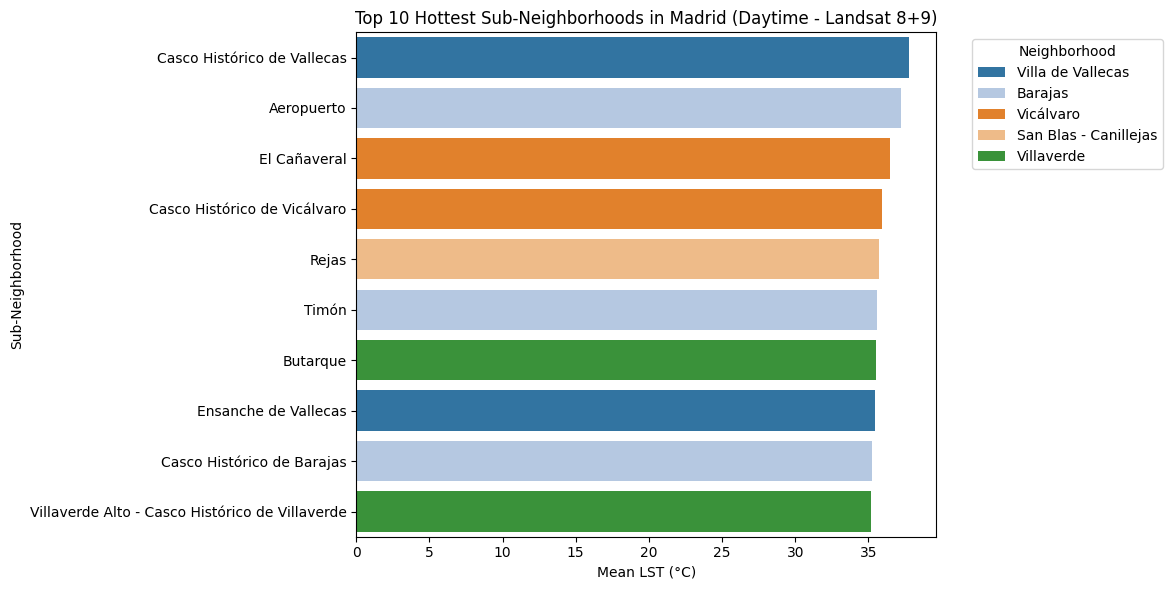

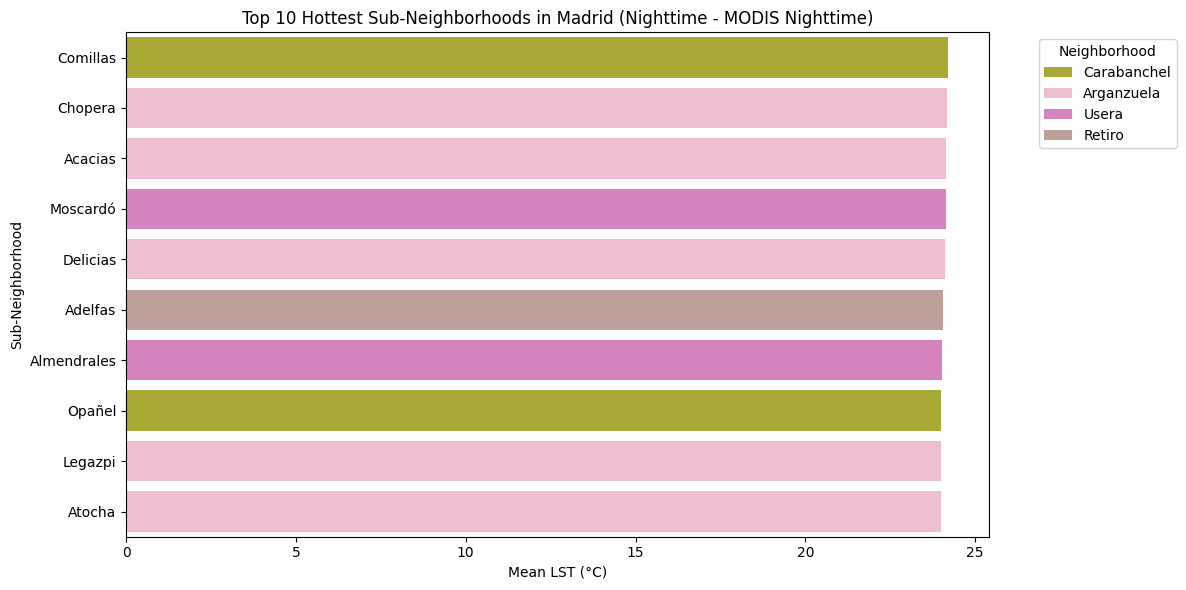

In [ ]:
def analyze_sub_neighborhood_lst(image, dataset_name):
    """
    Compute mean LST for all sub-neighborhoods only.
    """
    results = []

    for neighborhood, sub_neighborhoods in neighborhood_to_sub.items():
        for sub_neighborhood in sub_neighborhoods:
            sub_neighborhood_fc = neighborhoods.filter(ee.Filter.eq("NOMBRE", sub_neighborhood))

            lst_value = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=sub_neighborhood_fc.geometry(),
                scale=500,
                bestEffort=True,
                maxPixels=1e9
            ).get("LST_Celsius")

            try:
                lst_celsius = lst_value.getInfo()
            except:
                lst_celsius = None

            results.append({
                "Neighborhood": neighborhood,
                "Sub-Neighborhood": sub_neighborhood,
                "Dataset": dataset_name,
                "Mean_LST_C": lst_celsius
            })

    return pd.DataFrame(results).sort_values("Mean_LST_C", ascending=False)

# Analyze only sub-neighborhoods (no aggregation)
df_sub_neighborhoods_lst_merged = analyze_sub_neighborhood_lst(landsat_merged_lst, "Landsat 8+9")
df_sub_neighborhoods_modis_night = analyze_sub_neighborhood_lst(modis_lst, "MODIS Nighttime")

df_top10_hottest_day = df_sub_neighborhoods_lst_merged.head(10)
df_top10_hottest_night = df_sub_neighborhoods_modis_night.head(10)

print("\nTop 10 Hottest Sub-Neighborhoods in Madrid (Daytime - Landsat 8+9):")
print(df_top10_hottest_day)

print("\nTop 10 Hottest Sub-Neighborhoods in Madrid (Nighttime - MODIS Nighttime):")
print(df_top10_hottest_night)

# Assign colors to neighborhoods (ensuring sub-neighborhoods of the same neighborhood share the same color)
unique_neighborhoods = df_sub_neighborhoods_lst_merged["Neighborhood"].unique()
color_palette = sns.color_palette("tab20", len(unique_neighborhoods))  # More colors to avoid confusion
color_dict = dict(zip(unique_neighborhoods, color_palette))

# Plot barplot for top 10 hottest sub-neighborhoods during daytime
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top10_hottest_day, y="Sub-Neighborhood", x="Mean_LST_C", hue="Neighborhood", palette=color_dict)

# Labels and title
plt.xlabel("Mean LST (°C)")
plt.ylabel("Sub-Neighborhood")
plt.title("Top 10 Hottest Sub-Neighborhoods in Madrid (Daytime - Landsat 8+9)")
plt.legend(title="Neighborhood", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot barplot for top 10 hottest sub-neighborhoods during nighttime
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top10_hottest_night, y="Sub-Neighborhood", x="Mean_LST_C", hue="Neighborhood", palette=color_dict)

# Labels and title
plt.xlabel("Mean LST (°C)")
plt.ylabel("Sub-Neighborhood")
plt.title("Top 10 Hottest Sub-Neighborhoods in Madrid (Nighttime - MODIS Nighttime)")
plt.legend(title="Neighborhood", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## LST in Urban vs Vegetation Area

In [ ]:
def compute_landsat_ndvi(year):
    """Loads and processes Landsat NDVI for a given year."""
    if year < 2013:
        landsat_collection = 'LANDSAT/LT05/C02/T1_L2'  # Landsat 5 (1984-2012)
        nir_band, red_band = 'SR_B4', 'SR_B3'
    else:
        landsat_collection = 'LANDSAT/LC08/C02/T1_L2'  # Landsat 8 (2013-Present)
        nir_band, red_band = 'SR_B5', 'SR_B4'

    # Load Landsat collection (summer months: June–August)
    landsat_ndvi = ee.ImageCollection(landsat_collection) \
        .filterDate(f'{year}-06-01', f'{year}-08-31') \
        .map(lambda img: img.normalizedDifference([nir_band, red_band]).rename('NDVI'))  # Compute NDVI

    return landsat_ndvi.median()  # Compute median NDVI over summer months



Processing LST for Madrid Urban Area using MODIS Nighttime (Nighttime)...
Cooling effect of tree cover (Madrid Urban Area, Nighttime): 2.77°C
Processing LST for Madrid Region using MODIS Nighttime (Nighttime)...
Cooling effect of tree cover (Madrid Region, Nighttime): 2.81°C
Processing LST for Area of Interest (Selected 9 Districts) using MODIS Nighttime (Nighttime)...
Cooling effect of tree cover (Area of Interest (Selected 9 Districts), Nighttime): 0.47°C


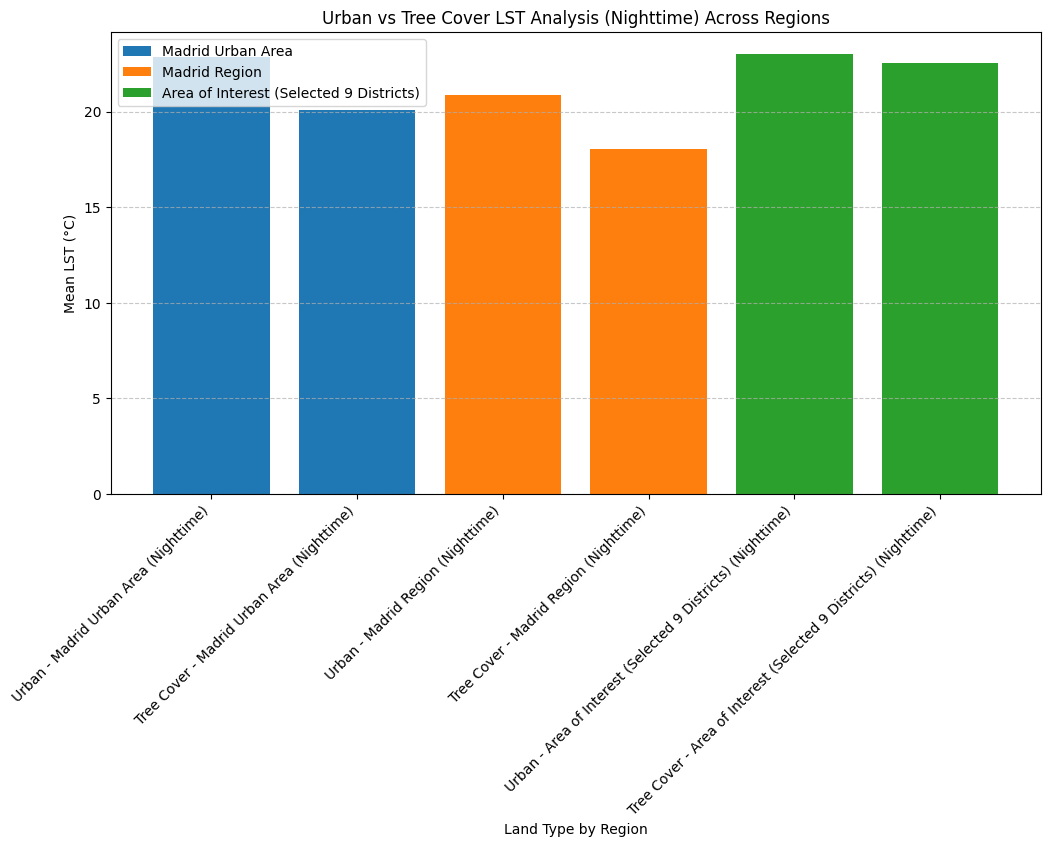


Urban vs Tree Cover LST Analysis (Nighttime) Across Regions:
                                    Region   Land Type          Dataset  \
0                        Madrid Urban Area       Urban  MODIS Nighttime   
1                        Madrid Urban Area  Tree Cover  MODIS Nighttime   
2                            Madrid Region       Urban  MODIS Nighttime   
3                            Madrid Region  Tree Cover  MODIS Nighttime   
4  Area of Interest (Selected 9 Districts)       Urban  MODIS Nighttime   
5  Area of Interest (Selected 9 Districts)  Tree Cover  MODIS Nighttime   

  Time of Day  Mean LST (°C)  
0   Nighttime      22.857520  
1   Nighttime      20.085511  
2   Nighttime      20.868100  
3   Nighttime      18.058168  
4   Nighttime      23.016204  
5   Nighttime      22.550910  


In [ ]:
# Function to analyze LST differences across multiple regions for both daytime and nighttime
def analyze_lst_for_regions(image, ndvi_image, dataset_name, time_of_day, regions_dict):
    """
    Compute LST for different regions: Madrid Urban Area, Madrid Region,
    and selected 9 districts combined as one area of interest.
    """
    results = []

    for region_name, region_fc in regions_dict.items():
        print(f"Processing LST for {region_name} using {dataset_name} ({time_of_day})...")

        # Ensure correct LST band is used
        if "LST_Celsius" not in image.bandNames().getInfo():
            lst_image = scale_thermal_bands(image, dataset_name).clip(region_fc)
        else:
            lst_image = image.clip(region_fc)

        # Load Dynamic World land cover classification
        dynamic_world = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
            .filterBounds(region_fc) \
            .select('label') \
            .mode()

        # Use precomputed NDVI image
        ndvi = ndvi_image.clip(region_fc)

        # Define masks for urban and tree-covered areas (exclude clouds)
        urban_mask = dynamic_world.eq(6).And(dynamic_world.neq(8))  # Urban areas, exclude clouds
        tree_mask = dynamic_world.eq(1).And(dynamic_world.neq(8))  # Trees, exclude clouds

        # Compute mean LST for Urban and Trees
        urban_stats = lst_image.updateMask(urban_mask).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region_fc.geometry(),
            scale=500,
            bestEffort=True,
            maxPixels=1e9
        )

        tree_stats = lst_image.updateMask(tree_mask).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region_fc.geometry(),
            scale=500,
            bestEffort=True,
            maxPixels=1e9
        )

        # Extract temperature values
        try:
            urban_lst = urban_stats.get("LST_Celsius").getInfo()
            tree_lst = tree_stats.get("LST_Celsius").getInfo()
        except:
            urban_lst, tree_lst = None, None

        # Compute cooling effect of tree cover
        cooling_effect = urban_lst - tree_lst if urban_lst and tree_lst else None
        print(f"Cooling effect of tree cover ({region_name}, {time_of_day}): {cooling_effect:.2f}°C" if cooling_effect else "Cooling effect: Data unavailable")

        # Store results
        results.append({
            "Region": region_name,
            "Land Type": "Urban",
            "Dataset": dataset_name,
            "Time of Day": time_of_day,
            "Mean LST (°C)": urban_lst
        })
        results.append({
            "Region": region_name,
            "Land Type": "Tree Cover",
            "Dataset": dataset_name,
            "Time of Day": time_of_day,
            "Mean LST (°C)": tree_lst
        })

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # Plot histogram
    plt.figure(figsize=(12, 6))
    for region in df_results["Region"].unique():
        df_subset = df_results[df_results["Region"] == region]
        plt.bar(df_subset["Land Type"] + " - " + region + " (" + time_of_day + ")", df_subset["Mean LST (°C)"], label=region)

    plt.xlabel("Land Type by Region")
    plt.ylabel("Mean LST (°C)")
    plt.title(f"Urban vs Tree Cover LST Analysis ({time_of_day}) Across Regions")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return df_results

# Define regions
regions_dict = {
    "Madrid Urban Area": madrid_urban,
    "Madrid Region": madrid_region,
    "Area of Interest (Selected 9 Districts)": neighborhoods.filter(ee.Filter.inList("NOMDIS", selected_districts))
}

# Run urban vs tree LST analysis
df_urban_tree_modis_night = analyze_lst_for_regions(modis_lst, modis_ndvi, "MODIS Nighttime", "Nighttime", regions_dict)

# Combine results
df_urban_tree_combined = pd.concat([df_urban_tree_modis_night]).reset_index(drop=True)

# Print results
print("\nUrban vs Tree Cover LST Analysis (Nighttime) Across Regions:")
print(df_urban_tree_combined)

# Save results to CSV
df_urban_tree_combined.to_csv("urban_vs_tree_lst_day_night_regions.csv", index=False)

# PEARSON CORRELATION: LST & NDVI

In [ ]:
# Load MODIS LST (Daytime)
modis_lst = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filter(ee.Filter.calendarRange(6, 8, 'month')) \
    .mean() \
    .select("LST_Day_1km") \
    .multiply(0.02).subtract(273.15)  # Convert to Celsius

# Load MODIS NDVI
modis_ndvi = ee.ImageCollection('MODIS/061/MOD13A1') \
    .filter(ee.Filter.calendarRange(6, 8, 'month')) \
    .mean() \
    .select("NDVI") \
    .multiply(0.0001)  # Apply scale factor

# Load Madrid Urban Area
madrid_urban = ee.FeatureCollection("projects/ee-lvillaxieu2020/assets/mad")

# Load Neighborhoods Feature Collection (for filtering selected districts)
neighborhoods = ee.FeatureCollection("projects/ee-lvillaxieu2020/assets/Barrios")

# Define selected districts
selected_districts = [
    "Vicálvaro", "San Blas - Canillejas", "Villa de Vallecas",
    "Villaverde", "Puente de Vallecas", "Moratalaz",
    "Latina", "Carabanchel", "Usera"
]

# Filter to only include selected districts
selected_districts_fc = neighborhoods.filter(ee.Filter.inList("NOMDIS", selected_districts))

# Load Dynamic World for Tree Cover Filtering
dw_landcover = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1") \
    .filterDate("2024-06-01", "2024-08-31") \
    .mode()  # Use mode to get the most common land cover category

# Create Different Masks:
# (A) NDVI ≥ 0.4 (Vegetation areas)
ndvi_vegetation_mask = modis_ndvi.gte(0.4)
lst_ndvi_filtered = modis_lst.updateMask(ndvi_vegetation_mask)
ndvi_filtered = modis_ndvi.updateMask(ndvi_vegetation_mask)

# (B) Dynamic World Trees (Category 2)
tree_mask = dw_landcover.select("label").eq(2)
lst_trees_filtered = modis_lst.updateMask(tree_mask)
ndvi_trees_filtered = modis_ndvi.updateMask(tree_mask)

# Sampling scale
sample_scale = 250  # MODIS resolution in meters

# Dictionary to store NDVI and LST values for plotting
correlation_results = {}

def compute_correlation(lst_image, ndvi_image, region, region_name, mask_description):
    # Sample points in specified region
    sample_points = lst_image.addBands(ndvi_image) \
        .sampleRegions(
            collection=region,
            scale=sample_scale,
            geometries=False
        ).limit(5000)

    # Extract NDVI and LST values
    sample_dict = sample_points.reduceColumns(
        reducer=ee.Reducer.toList(2),
        selectors=["NDVI", "LST_Day_1km"]
    ).getInfo()

    # Convert to NumPy arrays
    ndvi_values = np.array(sample_dict["list"])[:, 0]
    lst_values = np.array(sample_dict["list"])[:, 1]

    # Compute Pearson's correlation
    pearson_corr, p_value = stats.pearsonr(ndvi_values, lst_values)

    num_samples = len(ndvi_values)
    print(f"Pearson's Correlation ({mask_description} in {region_name}): {pearson_corr:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Number of samples used: {num_samples}\n")

    # Store data for plotting
    correlation_results[f"{region_name} - {mask_description}"] = (ndvi_values, lst_values)

In [ ]:
# Compute Pearson’s Correlation for Madrid Urban
print("=== Madrid Urban ===")
compute_correlation(lst_ndvi_filtered, ndvi_filtered, madrid_urban, "Madrid Urban", "NDVI ≥ 0.4")
compute_correlation(lst_trees_filtered, ndvi_trees_filtered, madrid_urban, "Madrid Urban", "Dynamic World Trees")
compute_correlation(modis_lst, modis_ndvi, madrid_urban, "Madrid Urban", "Full Urban Area - No Filtering")

# Compute Pearson’s Correlation for Selected Districts
print("\n=== Selected Area ===")
compute_correlation(lst_ndvi_filtered, ndvi_filtered, selected_districts_fc, "Selected Area", "NDVI ≥ 0.4")
compute_correlation(lst_trees_filtered, ndvi_trees_filtered, selected_districts_fc, "Selected Area", "Dynamic World Trees")
compute_correlation(modis_lst, modis_ndvi, selected_districts_fc, "Selected Area", "Selected Area - No Filtering")

=== Madrid Urban ===
Pearson's Correlation (NDVI ≥ 0.4 in Madrid Urban): -0.5648
P-value: 0.0000
Number of samples used: 2177

Pearson's Correlation (Dynamic World Trees in Madrid Urban): -0.6804
P-value: 0.0000
Number of samples used: 55

Pearson's Correlation (Full Urban Area - No Filtering in Madrid Urban): -0.5014
P-value: 0.0000
Number of samples used: 5000


=== Selected Area ===
Pearson's Correlation (NDVI ≥ 0.4 in Selected Area): 0.9102
P-value: 0.0001
Number of samples used: 11

Pearson's Correlation (Dynamic World Trees in Selected Area): 0.6186
P-value: 0.0320
Number of samples used: 12

Pearson's Correlation (Selected Area - No Filtering in Selected Area): -0.4754
P-value: 0.0000
Number of samples used: 4155



### Plot

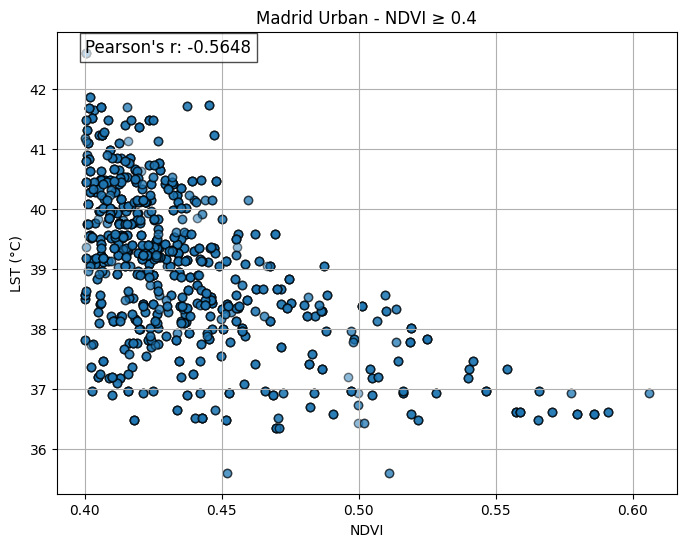

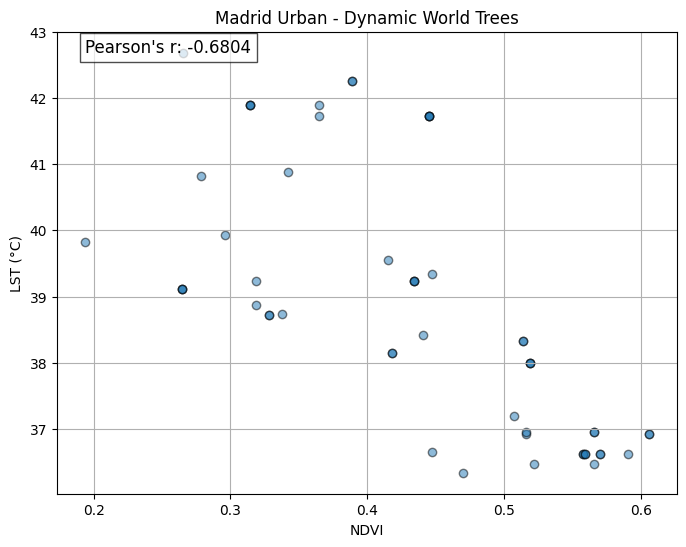

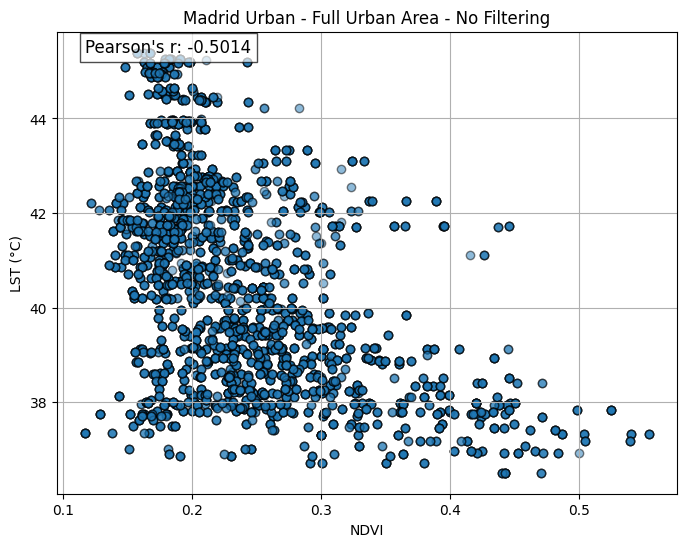

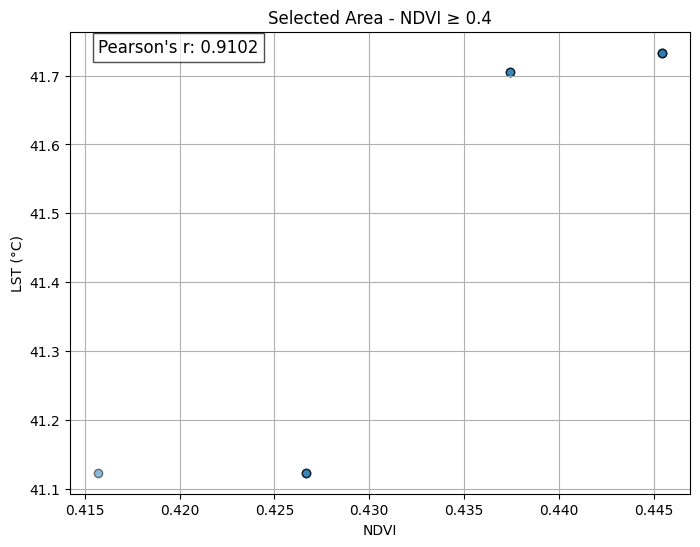

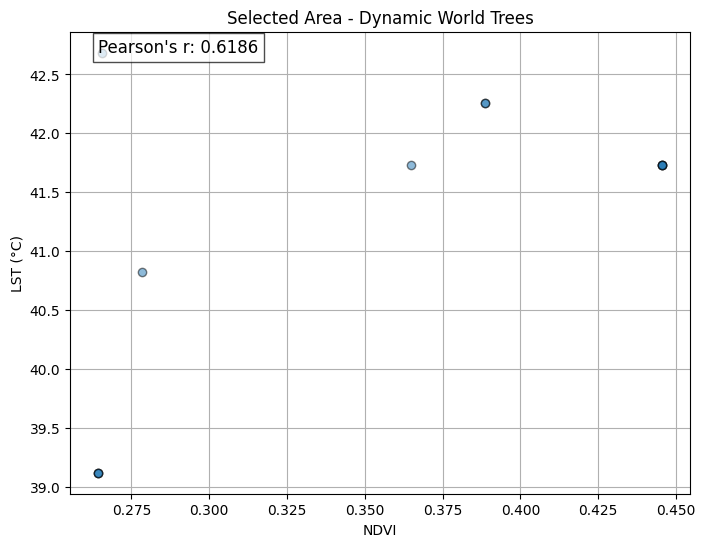

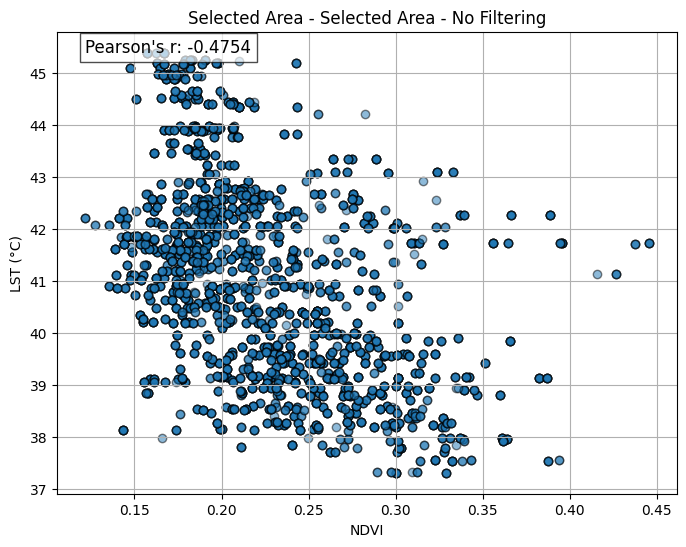

In [ ]:
# Function to generate scatter plots
def plot_scatter(ndvi_values, lst_values, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(ndvi_values, lst_values, alpha=0.5, edgecolors='k')
    plt.xlabel("NDVI")
    plt.ylabel("LST (°C)")
    plt.title(title)

    # Compute Pearson's correlation
    pearson_corr, _ = stats.pearsonr(ndvi_values, lst_values)

    # Display correlation value
    plt.text(min(ndvi_values), max(lst_values), f"Pearson's r: {pearson_corr:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.grid(True)
    plt.show()

# Generate scatter plots for all stored results
for key, (ndvi_vals, lst_vals) in correlation_results.items():
    plot_scatter(ndvi_vals, lst_vals, key)

# UHI EFFECT (nighttime)

In [ ]:
# Compute the rural area (periphery) by subtracting the urban area from the region
periphery = madrid_region.geometry().difference(madrid_urban.geometry())

In [ ]:
# Load MODIS LST (Nighttime)
modis_lst_night = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filter(ee.Filter.calendarRange(6, 8, 'month')) \
    .mean() \
    .select("LST_Night_1km")  # Select nighttime LST

# Define Rest of Urban Area (Madrid Urban - Selected Districts)
rest_of_urban = madrid_urban.geometry().difference(selected_districts_fc.geometry())

# Function to compute Mean LST in Celsius (applying MODIS scale factor)
def compute_mean_lst(region, modis_lst):
    return ee.Number(modis_lst.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=1000,  # MODIS LST resolution
        bestEffort=True
    ).get("LST_Night_1km")).multiply(0.02).subtract(273.15)  # Apply scale factor & convert to Celsius

# Compute Mean LST in Celsius for Nighttime
lst_urban_C_night = compute_mean_lst(madrid_urban, modis_lst_night)
lst_periphery_C_night = compute_mean_lst(periphery, modis_lst_night)
lst_selected_districts_C_night = compute_mean_lst(selected_districts_fc, modis_lst_night)
lst_rest_of_urban_C_night = compute_mean_lst(rest_of_urban, modis_lst_night)

# Compute Absolute UHI Effect for Nighttime
uhi_urban_vs_periphery_night = lst_urban_C_night.subtract(lst_periphery_C_night)
uhi_selected_vs_periphery_night = lst_selected_districts_C_night.subtract(lst_periphery_C_night)
uhi_rest_of_urban_vs_periphery_night = lst_rest_of_urban_C_night.subtract(lst_periphery_C_night)
uhi_rest_of_urban_vs_selected_night = lst_rest_of_urban_C_night.subtract(lst_selected_districts_C_night)

# Print Results in Celsius for Nighttime
print("=== NIGHTTIME UHI EFFECT ===")
print("Mean LST (Urban):", lst_urban_C_night.getInfo(), "°C")
print("Mean LST (Periphery):", lst_periphery_C_night.getInfo(), "°C")
print("Mean LST (Selected Districts):", lst_selected_districts_C_night.getInfo(), "°C")
print("Mean LST (Rest of Urban):", lst_rest_of_urban_C_night.getInfo(), "°C")

print("\nAbsolute UHI Effects (Nighttime):")
print("Urban vs Periphery:", uhi_urban_vs_periphery_night.getInfo(), "°C")
print("Selected Districts vs Periphery:", uhi_selected_vs_periphery_night.getInfo(), "°C")
print("Rest of Urban vs Periphery:", uhi_rest_of_urban_vs_periphery_night.getInfo(), "°C")
print("Rest of Urban vs Selected Districts:", uhi_rest_of_urban_vs_selected_night.getInfo(), "°C")

=== NIGHTTIME UHI EFFECT ===
Mean LST (Urban): 21.51271425274831 °C
Mean LST (Periphery): 18.863346595303597 °C
Mean LST (Selected Districts): 22.262646542842617 °C
Mean LST (Rest of Urban): 21.112420546641886 °C

Absolute UHI Effects (Nighttime):
Urban vs Periphery: 2.6493676574447136 °C
Selected Districts vs Periphery: 3.3992999475390206 °C
Rest of Urban vs Periphery: 2.249073951338289 °C
Rest of Urban vs Selected Districts: -1.1502259962007315 °C


In [ ]:
#Reference lines
uhi_urban_vs_periphery_night_val = uhi_urban_vs_periphery_night.getInfo()
uhi_selected_vs_periphery_night_val = uhi_selected_vs_periphery_night.getInfo()

## All Madrid Neighbourhoods

In [ ]:
# Compute Mean LST for Periphery (Nighttime)
lst_periphery_C_night = compute_mean_lst(periphery, modis_lst_night)

# Dictionary to store UHI results for all neighborhoods
neighborhoods_uhi_night = {}

# Get all unique neighborhood names (NOMDIS)
neighborhood_list = neighborhoods.aggregate_array("NOMDIS").distinct().getInfo()

# Compute Mean LST and UHI Effect for Each Neighborhood (Nighttime)
for neighborhood in neighborhood_list:
    neighborhood_fc = neighborhoods.filter(ee.Filter.eq("NOMDIS", neighborhood))
    lst_neighborhood_C_night = compute_mean_lst(neighborhood_fc, modis_lst_night)
    uhi_effect_night = lst_neighborhood_C_night.subtract(lst_periphery_C_night)

    # Store results
    neighborhoods_uhi_night[neighborhood] = {
        "Mean LST (°C)": lst_neighborhood_C_night.getInfo(),
        "UHI Effect (°C)": uhi_effect_night.getInfo()
    }

# Print Results (Nighttime)
print("=== NIGHTTIME UHI EFFECT PER NEIGHBORHOOD ===")
print("Mean LST (Periphery):", lst_periphery_C_night.getInfo(), "°C\n")

for neighborhood, values in neighborhoods_uhi_night.items():
    print(f"{neighborhood}:")
    print(f"  Mean LST: {values['Mean LST (°C)']} °C")
    print(f"  UHI Effect (vs Periphery): {values['UHI Effect (°C)']} °C\n")

=== NIGHTTIME UHI EFFECT PER NEIGHBORHOOD ===
Mean LST (Periphery): 18.863346595303597 °C

Centro:
  Mean LST: 23.636704894694276 °C
  UHI Effect (vs Periphery): 4.773358299390679 °C

Arganzuela:
  Mean LST: 24.00926149628475 °C
  UHI Effect (vs Periphery): 5.145914900981154 °C

Retiro:
  Mean LST: 23.859605996497635 °C
  UHI Effect (vs Periphery): 4.996259401194038 °C

Salamanca:
  Mean LST: 23.898572502493494 °C
  UHI Effect (vs Periphery): 5.035225907189897 °C

Chamartín:
  Mean LST: 23.82397442305097 °C
  UHI Effect (vs Periphery): 4.960627827747373 °C

Tetuán:
  Mean LST: 23.809978863476942 °C
  UHI Effect (vs Periphery): 4.946632268173346 °C

Chamberí:
  Mean LST: 23.778739140844266 °C
  UHI Effect (vs Periphery): 4.915392545540669 °C

Fuencarral - El Pardo:
  Mean LST: 19.9970591967342 °C
  UHI Effect (vs Periphery): 1.1337126014306023 °C

Moncloa - Aravaca:
  Mean LST: 21.76456148073669 °C
  UHI Effect (vs Periphery): 2.9012148854330917 °C

Latina:
  Mean LST: 21.90036017396187

### Plot

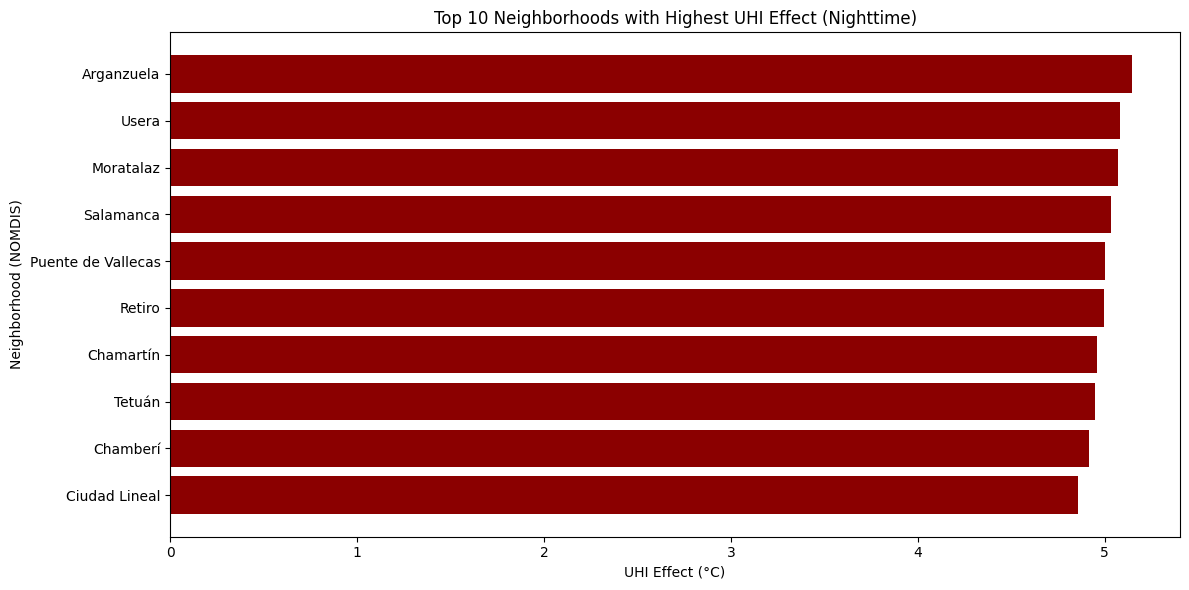

In [ ]:
# Convert UHI results dictionary into a DataFrame
df_uhi = pd.DataFrame.from_dict(neighborhoods_uhi_night, orient="index")

# Convert columns to numeric values
df_uhi["Mean LST (°C)"] = pd.to_numeric(df_uhi["Mean LST (°C)"], errors="coerce")
df_uhi["UHI Effect (°C)"] = pd.to_numeric(df_uhi["UHI Effect (°C)"], errors="coerce")

# Sort neighborhoods by highest UHI effect (descending)
df_top_10 = df_uhi.sort_values("UHI Effect (°C)", ascending=False).head(10)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.barh(df_top_10.index, df_top_10["UHI Effect (°C)"], color="darkred")

# Add labels and title
plt.xlabel("UHI Effect (°C)")
plt.ylabel("Neighborhood (NOMDIS)")
plt.title("Top 10 Neighborhoods with Highest UHI Effect (Nighttime)")
plt.gca().invert_yaxis()  # Invert y-axis so highest UHI is at the top

# Show plot
plt.tight_layout()
plt.show()

## Across Subneighbourhoods

In [ ]:
# Extract all sub-neighborhood names (NOMBRE)
subneighborhood_names = neighborhoods.aggregate_array("NOMBRE").distinct().getInfo()

# Dictionary to store UHI results for all sub-neighborhoods
subneighborhoods_uhi_night = {}

# Compute Mean LST for Periphery (Nighttime)
lst_periphery_C_night = compute_mean_lst(periphery, modis_lst_night)

# Compute Mean LST and UHI Effect for Each Sub-Neighborhood (Nighttime)
for subneighborhood in subneighborhood_names:
    subneighborhood_fc = neighborhoods.filter(ee.Filter.eq("NOMBRE", subneighborhood))
    lst_subneighborhood_C_night = compute_mean_lst(subneighborhood_fc, modis_lst_night)
    uhi_effect_night = lst_subneighborhood_C_night.subtract(lst_periphery_C_night)

    # Store results
    subneighborhoods_uhi_night[subneighborhood] = {
        "Mean LST (°C)": lst_subneighborhood_C_night.getInfo(),
        "UHI Effect (°C)": uhi_effect_night.getInfo()
    }

# Print Results (Nighttime)
print("=== NIGHTTIME UHI EFFECT PER SUB-NEIGHBORHOOD ===")
print("Mean LST (Periphery):", lst_periphery_C_night.getInfo(), "°C\n")

for subneighborhood, values in subneighborhoods_uhi_night.items():
    print(f"{subneighborhood}:")
    print(f"  Mean LST: {values['Mean LST (°C)']} °C")
    print(f"  UHI Effect (vs Periphery): {values['UHI Effect (°C)']} °C\n")

=== NIGHTTIME UHI EFFECT PER SUB-NEIGHBORHOOD ===
Mean LST (Periphery): 18.863346595303597 °C

Palacio:
  Mean LST: 23.555331843224337 °C
  UHI Effect (vs Periphery): 4.691985247920741 °C

Embajadores:
  Mean LST: 23.68073327264932 °C
  UHI Effect (vs Periphery): 4.8173866773457235 °C

Cortes:
  Mean LST: 23.63112536246348 °C
  UHI Effect (vs Periphery): 4.767778767159882 °C

Justicia:
  Mean LST: 23.690628243774825 °C
  UHI Effect (vs Periphery): 4.827281648471228 °C

Universidad:
  Mean LST: 23.683675691346878 °C
  UHI Effect (vs Periphery): 4.820329096043281 °C

Sol:
  Mean LST: 23.6289361667354 °C
  UHI Effect (vs Periphery): 4.7655895714318035 °C

Imperial:
  Mean LST: 23.884534878756767 °C
  UHI Effect (vs Periphery): 5.021188283453171 °C

Acacias:
  Mean LST: 24.10094413405625 °C
  UHI Effect (vs Periphery): 5.237597538752652 °C

Chopera:
  Mean LST: 24.114520997555303 °C
  UHI Effect (vs Periphery): 5.251174402251706 °C

Legazpi:
  Mean LST: 24.088771186719725 °C
  UHI Effect (

### Plot for higest UHI effect

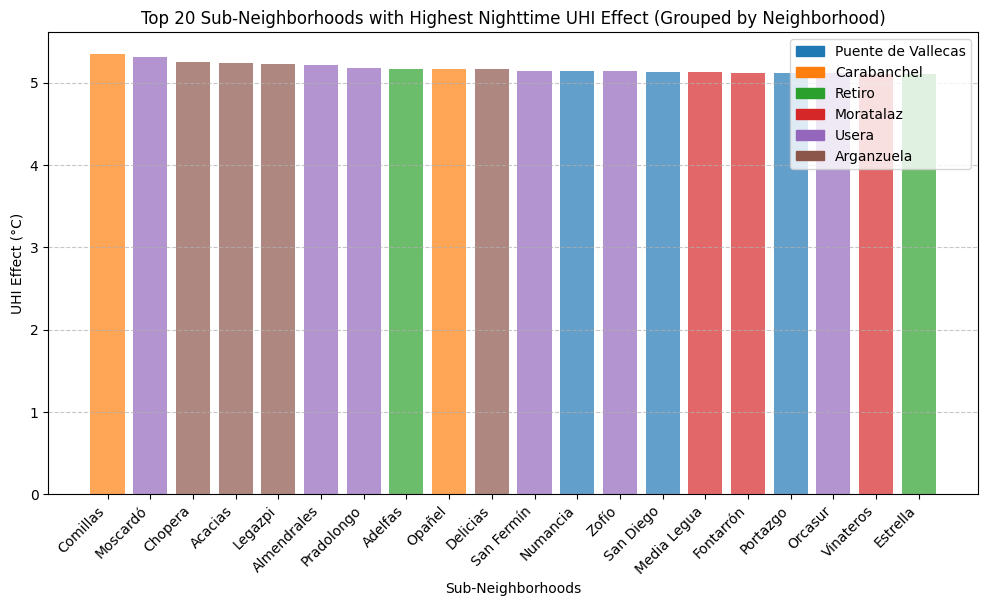

In [ ]:
# Extract data and sort by UHI effect
sorted_subneighborhoods = sorted(subneighborhoods_uhi_night.items(),
                                 key=lambda x: x[1]["UHI Effect (°C)"],
                                 reverse=True)  # Sort by UHI effect, descending

# Select the top 20 sub-neighborhoods
top_subneighborhoods = sorted_subneighborhoods[:20]

# Extract names and UHI values for plotting
top_20_names = [item[0] for item in top_subneighborhoods]
top_uhi_values = [item[1]["UHI Effect (°C)"] for item in top_subneighborhoods]

# Extract parent neighborhoods (from the original FeatureCollection)
top_20_parent_neighborhoods = []
for subneighborhood in top_20_names:
    parent_neighborhood = neighborhoods.filter(ee.Filter.eq("NOMBRE", subneighborhood)) \
                                       .aggregate_array("NOMDIS") \
                                       .getInfo()
    top_20_parent_neighborhoods.append(parent_neighborhood[0] if parent_neighborhood else "Unknown")

# Assign colors to each neighborhood
unique_neighborhoods = list(set(top_20_parent_neighborhoods))
color_map = {neigh: f"C{idx % 10}" for idx, neigh in enumerate(unique_neighborhoods)}  # Assign unique colors

# Create bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_20_names, top_uhi_values,
               color=[color_map[neigh] for neigh in top_20_parent_neighborhoods], alpha=0.7)

# Create legend items
legend_patches = [plt.Rectangle((0,0),1,1, color=color_map[neigh]) for neigh in unique_neighborhoods]
legend_labels = unique_neighborhoods + ["UHI - Madrid Urban vs Periphery", "UHI - Selected Districts vs Periphery"]

# Customize legend
plt.legend(legend_patches, legend_labels, loc="upper right")

# Customize plot
plt.xticks(rotation=45, ha="right")
plt.xlabel("Sub-Neighborhoods")
plt.ylabel("UHI Effect (°C)")
plt.title("Top 20 Sub-Neighborhoods with Highest Nighttime UHI Effect (Grouped by Neighborhood)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

### Plot for lowest UHI effect

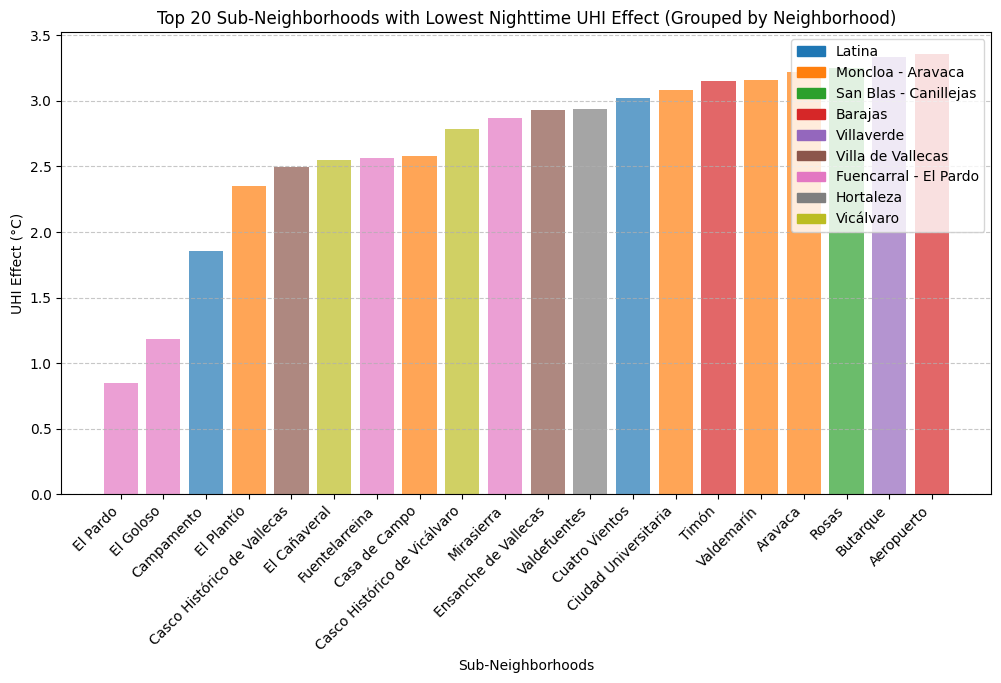

In [ ]:
# Extract data and sort by UHI effect
sorted_subneighborhoods = sorted(subneighborhoods_uhi_night.items(),
                                 key=lambda x: x[1]["UHI Effect (°C)"],
                                 reverse=False)  # Sort by UHI effect, descending

# Select the top 20 sub-neighborhoods
top_10_subneighborhoods = sorted_subneighborhoods[:20]

# Extract names and UHI values for plotting
top_10_names = [item[0] for item in top_10_subneighborhoods]
top_10_uhi_values = [item[1]["UHI Effect (°C)"] for item in top_10_subneighborhoods]

# Extract parent neighborhoods (from the original FeatureCollection)
top_10_parent_neighborhoods = []
for subneighborhood in top_10_names:
    parent_neighborhood = neighborhoods.filter(ee.Filter.eq("NOMBRE", subneighborhood)) \
                                       .aggregate_array("NOMDIS") \
                                       .getInfo()
    top_10_parent_neighborhoods.append(parent_neighborhood[0] if parent_neighborhood else "Unknown")

# Assign colors to each neighborhood
unique_neighborhoods = list(set(top_10_parent_neighborhoods))
color_map = {neigh: f"C{idx % 10}" for idx, neigh in enumerate(unique_neighborhoods)}  # Assign unique colors

# Create bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_names, top_10_uhi_values,
               color=[color_map[neigh] for neigh in top_10_parent_neighborhoods], alpha=0.7)

# Create legend items
legend_patches = [plt.Rectangle((0,0),1,1, color=color_map[neigh]) for neigh in unique_neighborhoods]
legend_labels = unique_neighborhoods + ["UHI - Madrid Urban vs Periphery", "UHI - Selected Districts vs Periphery"]

# Customize legend
plt.legend(legend_patches, legend_labels, loc="upper right")

# Customize plot
plt.xticks(rotation=45, ha="right")
plt.xlabel("Sub-Neighborhoods")
plt.ylabel("UHI Effect (°C)")
plt.title("Top 20 Sub-Neighborhoods with Lowest Nighttime UHI Effect (Grouped by Neighborhood)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

# REGRESSION

## Creating Dataframe

In [ ]:
# 1. Load and process MODIS LST (Nighttime) – scaled to Celsius
modis_lst_night = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filterDate('2023-06-01', '2023-08-31') \
    .select('LST_Night_1km') \
    .mean() \
    .multiply(0.02).subtract(273.15) \
    .rename('LST_Night_C')

# Load Sentinel-2 Harmonized for NDVI Analysis (2018-2024)
sentinel_2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate('2024-06-01', '2024-08-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .median()

def scale_ndvi(image, collection_name):
    # Sentinel-2 NDVI calculation
    if collection_name == 'COPERNICUS/S2_HARMONIZED':
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return ndvi
    print(f"Warning: NDVI band not found in {collection_name}")
    return image

sentinel_2_ndvi = scale_ndvi(sentinel_2, 'COPERNICUS/S2_HARMONIZED')

# 3. Compute periphery LST (baseline for UHI calculation)
periphery = madrid_region.geometry().difference(madrid_urban.geometry())

periphery_lst = ee.Number(
    modis_lst_night.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=periphery,
        scale=1000,
        maxPixels=1e9
    ).get('LST_Night_C')
).getInfo()

print(f"Periphery baseline night LST: {periphery_lst:.2f} °C")

# 4. Iterate through all sub-neighborhoods
subneigh_names = neighborhoods.aggregate_array("NOMBRE").getInfo()
results = []

for name in subneigh_names:
    try:
        fc = neighborhoods.filter(ee.Filter.eq("NOMBRE", name))
        geom = fc.geometry()

        # Get NDVI (mean)
        ndvi = sentinel_2_ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom,
            scale=250,
            maxPixels=1e9
        ).get('NDVI')

        # Get LST (mean, °C)
        lst = modis_lst_night.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom,
            scale=1000,
            maxPixels=1e9
        ).get('LST_Night_C')

        district = fc.first().get('NOMDIS').getInfo()

        # Calculate UHI (°C)
        uhi = ee.Number(lst).subtract(periphery_lst)

        selected_area = "yes" if district in selected_districts else "no"


        results.append({
            "SubNeighborhood": name,
            "District": district,
            "NDVI": ndvi.getInfo(),
            "LST_Night_C": lst.getInfo(),
            "UHI_Night_C": uhi.getInfo(),
            "SelectedArea": selected_area
        })

    except Exception as e:
        print(f"Error in {name}: {str(e)}")

# 5. Convert results to DataFrame
df = pd.DataFrame(results)
df.to_csv("NDVI_LST_UHI_SubNeighborhoods.csv", index=False)
print("Exported dataframe to 'NDVI_LST_UHI_SubNeighborhoods.csv'")
print(df.head())

Periphery baseline night LST: 20.83 °C
Exported dataframe to 'NDVI_LST_UHI_SubNeighborhoods.csv'
  SubNeighborhood District      NDVI  LST_Night_C  UHI_Night_C SelectedArea
0         Palacio   Centro  0.242186    25.276077     4.443213           no
1     Embajadores   Centro  0.098365    25.654042     4.821179           no
2          Cortes   Centro  0.105034    25.686130     4.853266           no
3        Justicia   Centro  0.110449    25.828767     4.995903           no
4     Universidad   Centro  0.094694    25.638045     4.805182           no


## Checking first hypothensis: LST and NDVI

### Regression

In [ ]:
print("--- Hypothesis 1: Cooling effect of vegetation ---")

# Add constant for intercept
X = sm.add_constant(df['NDVI'])
Y_night = df['LST_Night_C']

# Run regression for night LST
model_night = sm.OLS(Y_night, X).fit()
print("\nNight LST vs NDVI regression:")
print(model_night.summary())

# Extract key information
night_coef = model_night.params['NDVI']
night_pvalue = model_night.pvalues['NDVI']
night_r2 = model_night.rsquared

print("\nRegression Results Summary:")
print(f"Night LST ~ NDVI: coefficient = {night_coef:.4f}, p-value = {night_pvalue:.4f}, R² = {night_r2:.4f}")

--- Hypothesis 1: Cooling effect of vegetation ---

Night LST vs NDVI regression:
                            OLS Regression Results                            
Dep. Variable:            LST_Night_C   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     8.325
Date:                Mon, 21 Apr 2025   Prob (F-statistic):            0.00459
Time:                        09:59:16   Log-Likelihood:                -159.10
No. Observations:                 131   AIC:                             322.2
Df Residuals:                     129   BIC:                             327.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

### Create Scatter Plots with Regression Lines

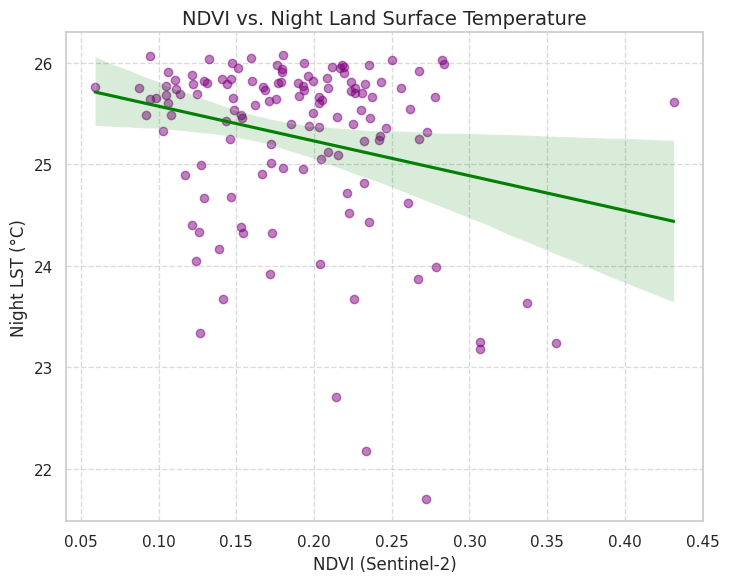

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [ ]:
# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# Night LST vs NDVI scatter plot
plt.subplot(1, 2, 2)
sns.regplot(x='NDVI', y='LST_Night_C', data=df,
            scatter_kws={'alpha':0.5, 'color':'purple'},
            line_kws={'color':'green'})
plt.title('NDVI vs. Night Land Surface Temperature', fontsize=14)
plt.xlabel('NDVI (Sentinel-2)', fontsize=12)
plt.ylabel('Night LST (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('ndvi_vs_lst_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# Also create a version highlighting the southeastern neighborhoods
plt.figure(figsize=(14, 6))

Negative Slope:
The regression line slopes downward, confirming the negative correlation seen in the statistical model.
→ Sub-neighborhoods with higher NDVI tend to have lower nighttime temperatures.

Scattered Points / Weak Fit:
Although there's a general trend, the points are widely dispersed around the line.
→ This aligns with the low R² value (~0.06) from the regression output, indicating the relationship is significant but not strong.

Confidence Band (Green Shaded Area):
The confidence interval widens as NDVI increases, likely due to fewer observations at the upper end of the NDVI range.
→ This suggests greater uncertainty in the cooling effect in greener areas, possibly due to variability in vegetation type (e.g., trees vs grass).

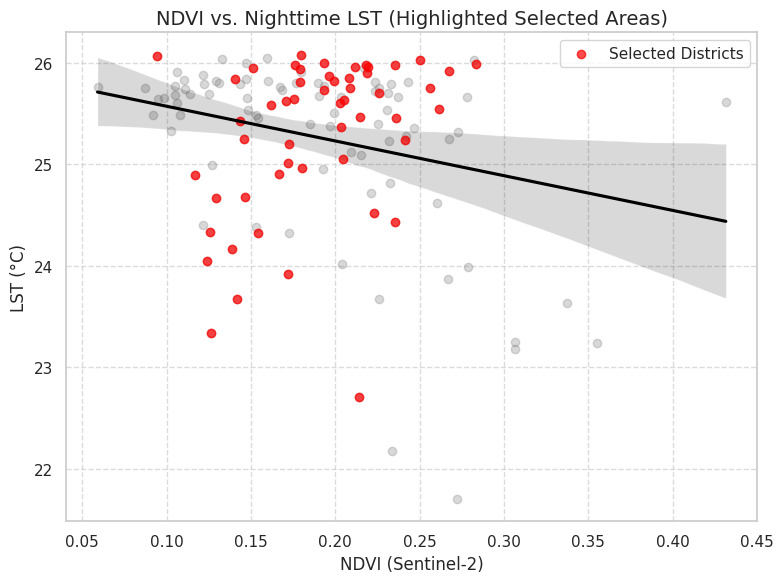

In [ ]:
# Function to create a combined scatter plot with highlighted points
def plot_with_highlights(x, y, data, ax, title):
    # Plot all points
    sns.regplot(x=x, y=y, data=data, ax=ax,
                scatter_kws={'alpha':0.3, 'color':'gray'},
                line_kws={'color':'black'})

    # Highlight selected southeastern neighborhoods
    se_data = data[data['SelectedArea'] == 'yes']
    ax.scatter(se_data[x], se_data[y], color='red', alpha=0.7,
               label='Selected Districts')

    # Add labels and legend
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('NDVI (Sentinel-2)', fontsize=12)
    ax.set_ylabel('LST (°C)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Create subplots (you can add ax1 if you're plotting something else later)
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the regression + highlights
plot_with_highlights('NDVI', 'LST_Night_C', df, ax, 'NDVI vs. Nighttime LST (Highlighted Selected Areas)')

plt.tight_layout()
plt.savefig('ndvi_vs_lst_selectedarea.png', dpi=300, bbox_inches='tight')
plt.show()

### Quantify Cooling Effect per 0.1 NDVI Increase

--- Quantified Cooling Effect of Vegetation ---
For each 0.1 increase in NDVI:
  • Night temperature decreases by 0.34°C (p=0.0046)

Cooling effect for different NDVI increases:
│ NDVI Increase │  Night Cooling (°C)
├───────────────┼──────────────────┤
│     0.05      │      0.17         │
│     0.10      │      0.34         │
│     0.15      │      0.51         │
│     0.20      │      0.68         │
│     0.25      │      0.85         │


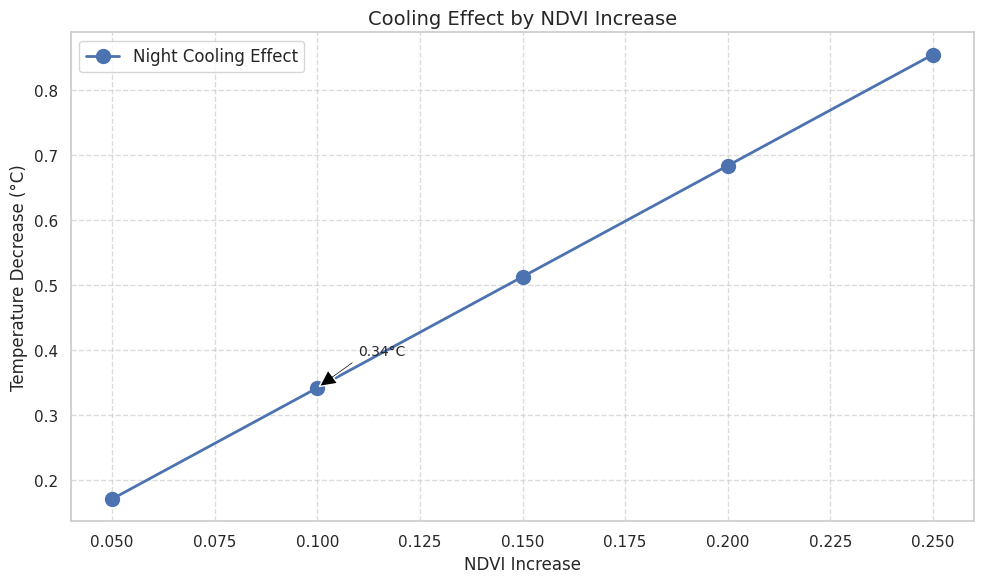

In [ ]:
X = sm.add_constant(df['NDVI'])
model_night = sm.OLS(df['LST_Night_C'], X).fit()

# Extract coefficient (slope) for NDVI
night_coef = model_night.params['NDVI']

# Cooling per 0.1 increase in NDVI
night_cooling_per_tenth = -night_coef * 0.1

print("--- Quantified Cooling Effect of Vegetation ---")
print(f"For each 0.1 increase in NDVI:")
print(f"  • Night temperature decreases by {night_cooling_per_tenth:.2f}°C (p={model_night.pvalues['NDVI']:.4f})")

# Try multiple NDVI increases
ndvi_increases = [0.05, 0.1, 0.15, 0.2, 0.25]
print("\nCooling effect for different NDVI increases:")
print("│ NDVI Increase │  Night Cooling (°C)")
print("├───────────────┼──────────────────┤")
for ndvi in ndvi_increases:
    night_effect = -night_coef * ndvi
    print(f"│     {ndvi:.2f}      │      {night_effect:.2f}         │")

# Plot the cooling effect
plt.figure(figsize=(10, 6))
x = np.array(ndvi_increases)
night_y = -night_coef * x

plt.plot(x, night_y, 'bo-', linewidth=2, markersize=10, label='Night Cooling Effect')

plt.xlabel('NDVI Increase', fontsize=12)
plt.ylabel('Temperature Decrease (°C)', fontsize=12)
plt.title('Cooling Effect by NDVI Increase', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Annotate the 0.1 NDVI effect
plt.annotate(f"{night_cooling_per_tenth:.2f}°C", xy=(0.1, -night_coef*0.1),
             xytext=(0.11, -night_coef*0.1+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

plt.tight_layout()
plt.savefig('cooling_effect_by_ndvi.png', dpi=300, bbox_inches='tight')
plt.show()

## Checking Second Hypothesis - Southeastern Neighborhoods UHI Comparison

### Regression

In [ ]:
# Load your cleaned DataFrame
df = pd.read_csv("NDVI_LST_UHI_SubNeighborhoods.csv")

# Step 1: Encode 'SelectedArea' column to binary
# ('yes' → 1 if part of southeastern districts, 'no' → 0)
df['Is_Southeastern'] = df['SelectedArea'].map({'yes': 1, 'no': 0})

# Step 2: Create predictor matrix (NDVI and SE status)
X = df[['NDVI', 'Is_Southeastern']]
X = sm.add_constant(X)  # Adds intercept

# Step 3: Define target variable
Y = df['UHI_Night_C']

# Step 4: Run multiple regression
model = sm.OLS(Y, X).fit()

# Step 5: Output summary
print("--- Multiple Regression: UHI ~ NDVI + Southeastern ---")
print(model.summary())

# Step 6: Quantify coefficients
coef_ndvi = model.params['NDVI']
coef_se = model.params['Is_Southeastern']
p_ndvi = model.pvalues['NDVI']
p_se = model.pvalues['Is_Southeastern']

print("\nInterpretation:")
print(f"• NDVI coefficient: {coef_ndvi:.3f} → For every 0.1 NDVI increase, UHI drops by {coef_ndvi * 0.1:.2f}°C (p={p_ndvi:.4f})")
print(f"• Southeastern coefficient: {coef_se:.3f} → SE areas are {coef_se:.2f}°C hotter on average, controlling for NDVI (p={p_se:.4f})")

# ---------------------------------------------
# OPTIONAL: Add interaction term (NDVI * SE)
# ---------------------------------------------
df['NDVI_x_SE'] = df['NDVI'] * df['Is_Southeastern']
X_interact = df[['NDVI', 'Is_Southeastern', 'NDVI_x_SE']]
X_interact = sm.add_constant(X_interact)

model_interact = sm.OLS(Y, X_interact).fit()

print("\n--- Interaction Model: UHI ~ NDVI * Southeastern ---")
print(model_interact.summary())

--- Multiple Regression: UHI ~ NDVI + Southeastern ---
                            OLS Regression Results                            
Dep. Variable:            UHI_Night_C   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.170
Date:                Mon, 21 Apr 2025   Prob (F-statistic):             0.0176
Time:                        09:59:19   Log-Likelihood:                -159.06
No. Observations:                 131   AIC:                             324.1
Df Residuals:                     128   BIC:                             332.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

# SOCIOECONOMIC DATA

## Variables

In [ ]:
# Read CSV correctly: semicolon separator, latin1 encoding
df_socioeconomic = pd.read_csv('Complete_SocioEconomic.csv', sep=';')

# Check the columns
df_socioeconomic.columns

df_socioeconomic.rename(columns={"Territory": "District", "Household average net rent": "Household average net income"}, inplace=True)

In [ ]:
df_socioeconomic.head()

,District,Unemployment rate,Household average net income,Percentage of foreign population
0,Arganzuela,"5,11",45.310,"12,5"
1,Barajas,"4,89",50.985,"11,6"
2,Carabanchel,"6,90",30.890,"25,8"
3,Centro,"5,34",36.984,"30,1"
4,Chamartin,"4,05",69.202,"12,3"


In [ ]:
# Replace commas with dots and convert to float for all numeric columns
df_socioeconomic['Unemployment rate'] = df_socioeconomic['Unemployment rate'].astype(str).str.replace(',', '.').astype(float)
df_socioeconomic['Household average net income'] = df_socioeconomic['Household average net income'].astype(str).str.replace(',', '.').astype(float)

In [ ]:
df_socioeconomic.head()

,District,Unemployment rate,Household average net income,Percentage of foreign population
0,Arganzuela,5.11,45.310,"12,5"
1,Barajas,4.89,50.985,"11,6"
2,Carabanchel,6.90,30.890,"25,8"
3,Centro,5.34,36.984,"30,1"
4,Chamartin,4.05,69.202,"12,3"


### Income

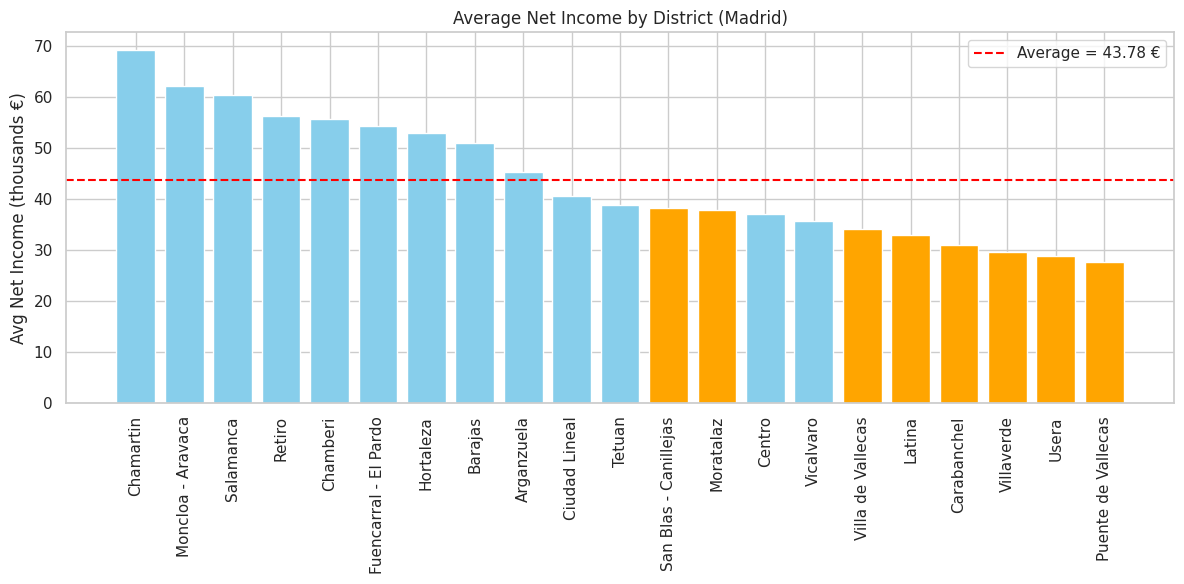

In [ ]:
# Sort the dataframe
df_sorted = df_socioeconomic.sort_values('Household average net income', ascending=False)

# Generate colors: one color for normal, another for highlighted districts
colors = ['orange' if district in selected_districts else 'skyblue' for district in df_sorted['District']]

# Calculate the average
average_rent = df_sorted['Household average net income'].mean()

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(df_sorted['District'], df_sorted['Household average net income'], color=colors)
plt.xticks(rotation=90)
plt.ylabel('Avg Net Income (thousands €)')
plt.title('Average Net Income by District (Madrid)')

# Add horizontal line for average
plt.axhline(average_rent, color='red', linestyle='--', label=f'Average = {average_rent:.2f} €')
plt.legend()

plt.tight_layout()
plt.show()

### Unemployment

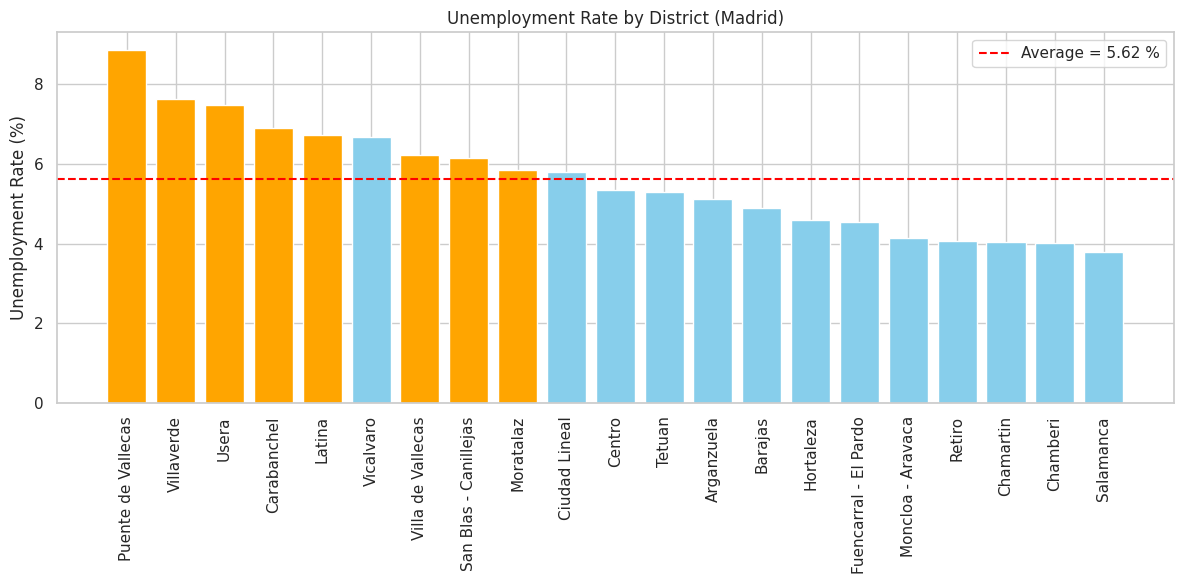

In [ ]:
# Sort by Unemployment Rate
df_unemp_sorted = df_socioeconomic.sort_values('Unemployment rate', ascending=False)

# Highlight the same districts
colors_unemp = ['orange' if district in selected_districts else 'skyblue' for district in df_unemp_sorted['District']]

# Calculate the average unemployment rate
average_unemp = df_unemp_sorted['Unemployment rate'].mean()

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(df_unemp_sorted['District'], df_unemp_sorted['Unemployment rate'], color=colors_unemp)
plt.xticks(rotation=90)
plt.ylabel('Unemployment Rate (%)')
plt.title('Unemployment Rate by District (Madrid)')

# Add horizontal line for average
plt.axhline(average_unemp, color='red', linestyle='--', label=f'Average = {average_unemp:.2f} %')
plt.legend()

plt.tight_layout()
plt.show()

### Vulnerability index

In [ ]:
# Read CSV correctly: semicolon separator, latin1 encoding
df_vulnerability = pd.read_csv('Vulnerability_Index.csv', sep=',')

columns_to_keep = [
    'NOMDIS', 'Indice_de_Vulnerabilidad_Territ',
    'Índice_de_Vulnerabilidad_Bienes',
    'Índice_de_Vulnerabilidad_Medio_',
    'Índice_de_Vulnerabilidad_Educac',
    'Índice_de_Vulnerabilidad_Econom',
    'Índice_de_Vulnerabilidad_Salud'
]

df_vuln = df_vulnerability[columns_to_keep]

df_vuln_grouped = df_vuln.groupby('NOMDIS').mean(numeric_only=True).reset_index()

df_vuln_grouped.rename(columns={"NOMDIS": "District"}, inplace=True)

In [ ]:
df_vuln_grouped.head()

,District,Indice_de_Vulnerabilidad_Territ,Índice_de_Vulnerabilidad_Bienes,Índice_de_Vulnerabilidad_Medio_,Índice_de_Vulnerabilidad_Educac,Índice_de_Vulnerabilidad_Econom,Índice_de_Vulnerabilidad_Salud
0,Arganzuela,6.472857,7.125714,5.444286,5.591429,5.518571,8.837143
1,Barajas,6.790000,7.996000,4.330000,5.134000,6.766000,9.140000
2,Carabanchel,9.398571,8.902857,6.900000,11.218571,12.130000,6.731429
3,Centro,8.991667,9.951667,11.928333,6.578333,6.961667,10.070000
4,Chamartín,6.203333,6.955000,7.238333,5.568333,4.791667,6.795000


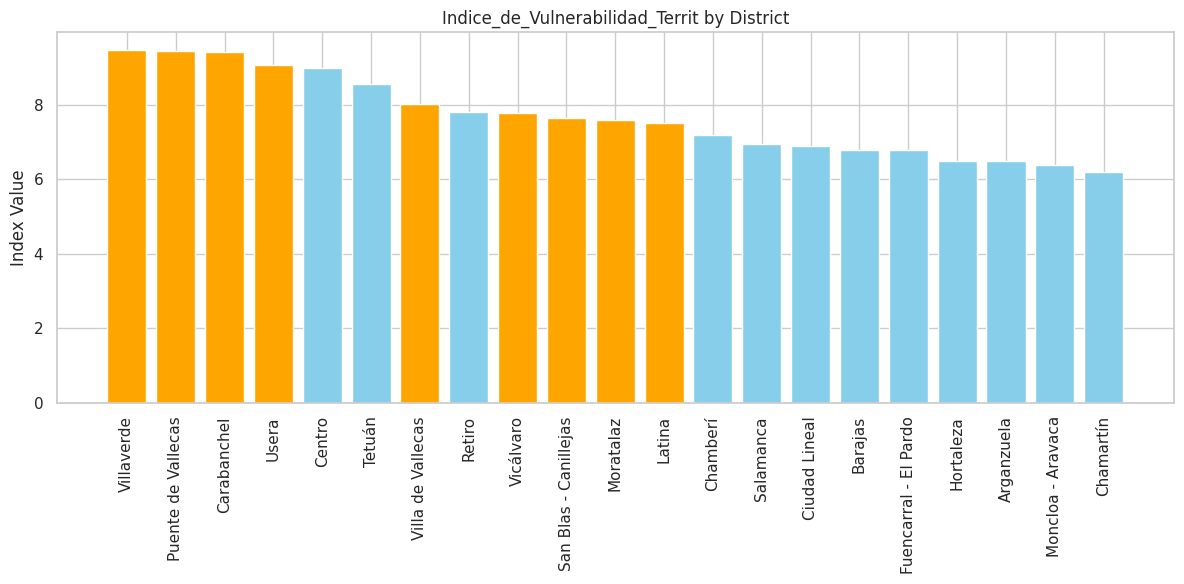

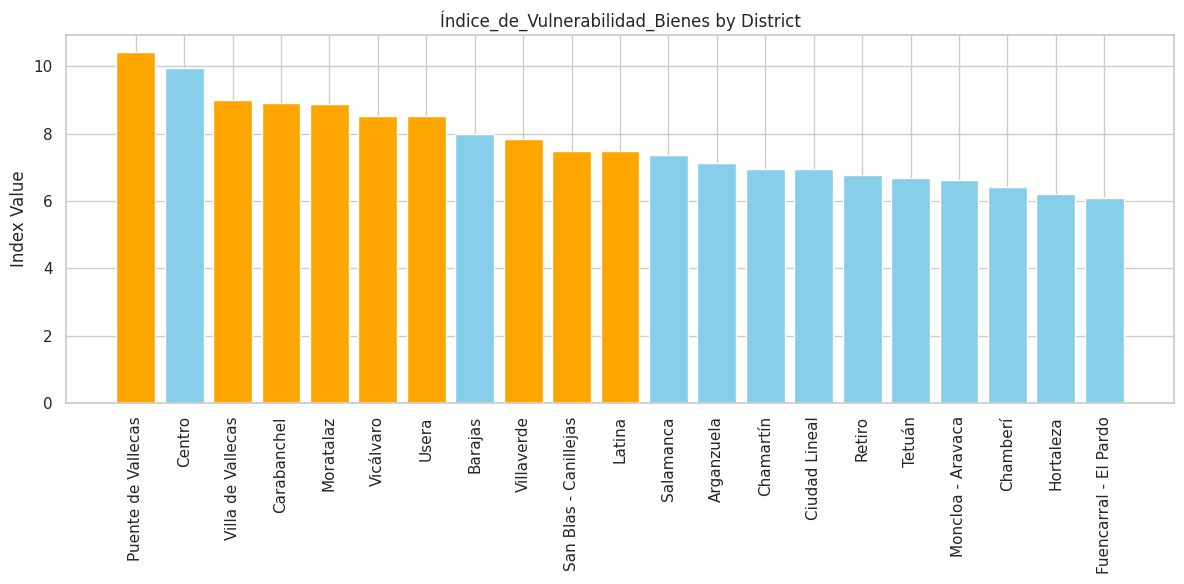

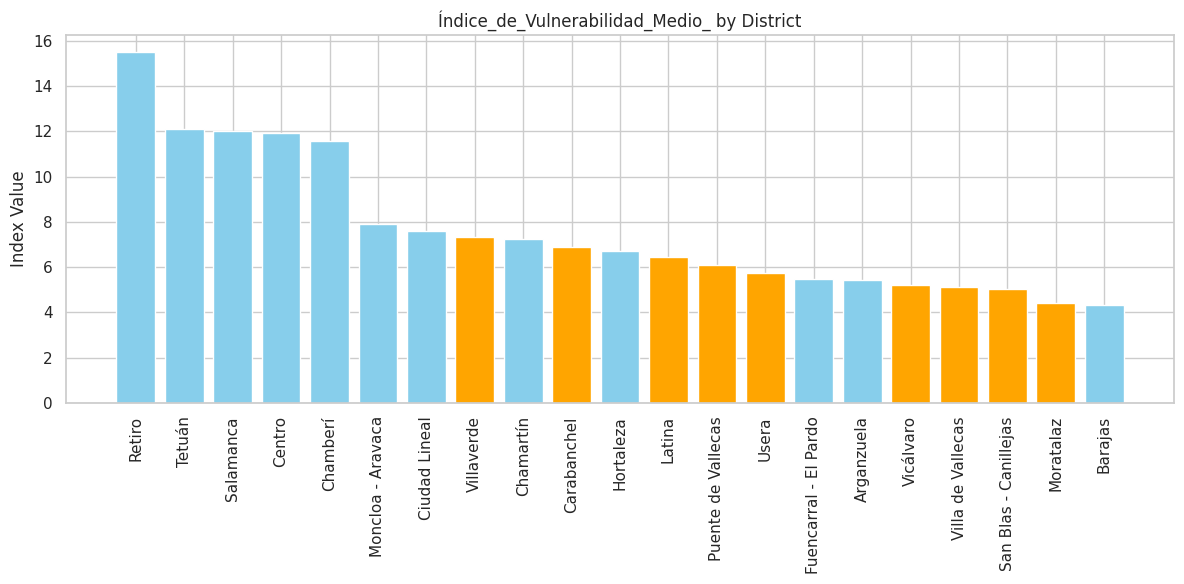

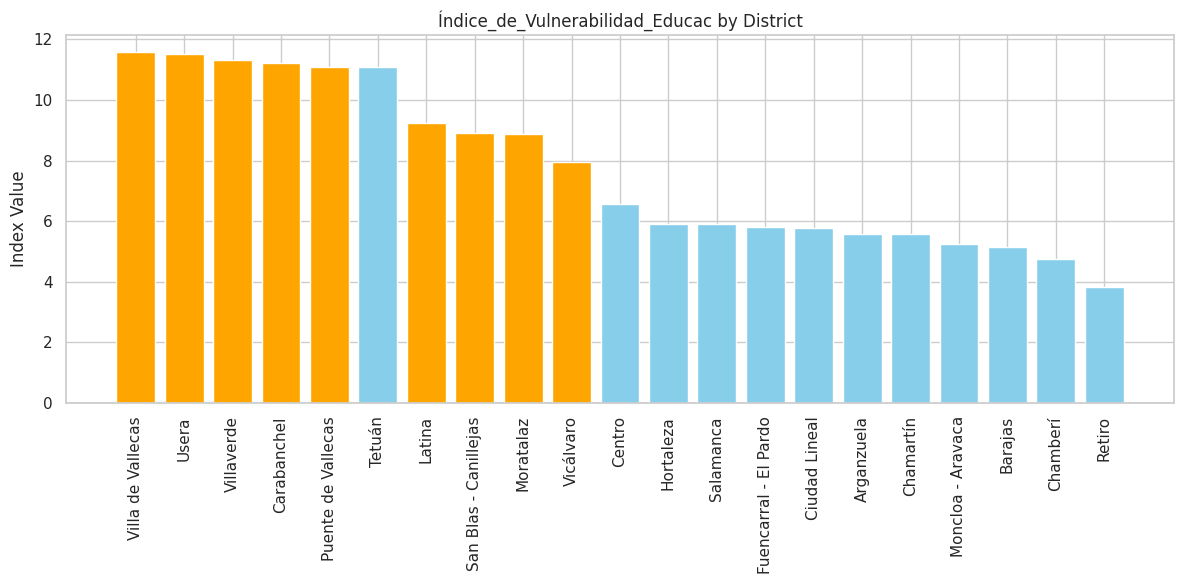

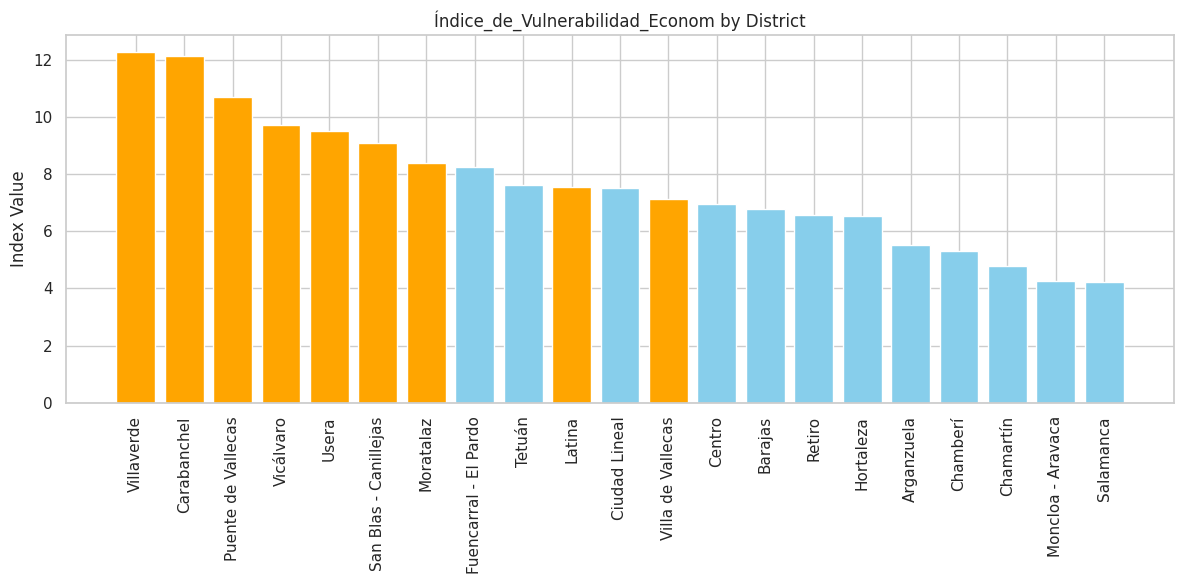

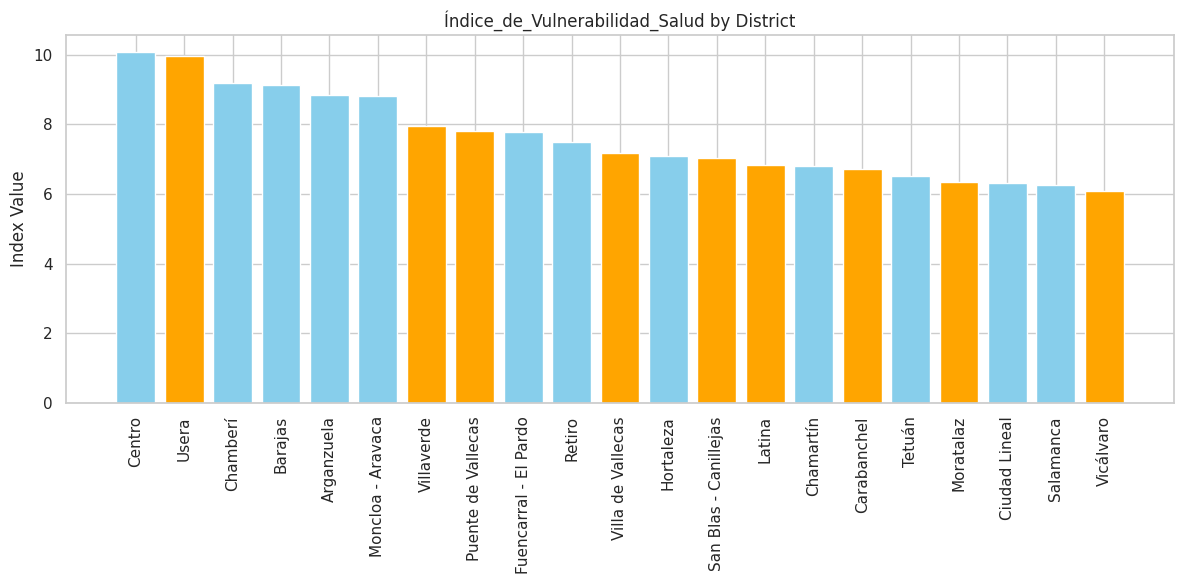

In [ ]:
vuln_columns = df_vuln_grouped.columns[1:]

# Plot each column
for col in vuln_columns:
    # Sort by this vulnerability column
    df_plot = df_vuln_grouped.sort_values(col, ascending=False)

    # Set colors: orange if it's a district you want to highlight
    colors = ['orange' if district in selected_districts else 'skyblue' for district in df_plot['District']]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(df_plot['District'], df_plot[col], color=colors)
    plt.xticks(rotation=90)
    plt.title(f'{col} by District')
    plt.ylabel('Index Value')
    plt.tight_layout()
    plt.show()

## Regresison with socioeconomic levels

### Combining dataframes

In [ ]:
# Clean column names if needed
df_combined = df.merge(df_socioeconomic, on="District", how="left")
df_combined = df_combined.merge(df_vuln_grouped[['District', 'Indice_de_Vulnerabilidad_Territ']], on="District", how="left")

In [ ]:
socio_vars = [
    'Unemployment rate',
    'Household average net income',
    'Indice_de_Vulnerabilidad_Territ'
]

print("\nPearson correlations with Night UHI:")
for var in socio_vars:
    corr = df_combined['UHI_Night_C'].corr(df_combined[var])
    print(f"• {var}: r = {corr:.3f}")


Pearson correlations with Night UHI:
• Unemployment rate: r = 0.241
• Household average net income: r = -0.306
• Indice_de_Vulnerabilidad_Territ: r = 0.259


### Regression with socioeconomic variables individually (controlling for vegetation)




In [ ]:
df_reg = df_combined.dropna(subset=socio_vars + ['NDVI', 'UHI_Night_C'])
y = df_reg['UHI_Night_C']

In [ ]:
# Unemployment + NDVI
X1 = sm.add_constant(df_reg[['Unemployment rate', 'NDVI']])
model1 = sm.OLS(y, X1).fit()
print("\nModel 1: Unemployment + NDVI")
print(model1.summary())

# Net Income + NDVI
X2 = sm.add_constant(df_reg[['Household average net income', 'NDVI']])
model2 = sm.OLS(y, X2).fit()
print("\nModel 2: Net Income + NDVI")
print(model2.summary())

# Vulnerability + NDVI
X3 = sm.add_constant(df_reg[['Indice_de_Vulnerabilidad_Territ', 'NDVI']])
model3 = sm.OLS(y, X3).fit()
print("\nModel 3: Vulnerability + NDVI")
print(model3.summary())


Model 1: Unemployment + NDVI
                            OLS Regression Results                            
Dep. Variable:            UHI_Night_C   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     6.555
Date:                Mon, 21 Apr 2025   Prob (F-statistic):            0.00207
Time:                        09:59:23   Log-Likelihood:                -135.22
No. Observations:                 109   AIC:                             276.4
Df Residuals:                     106   BIC:                             284.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

### Regression: Effect of vegetation cooling depending on vulnerability

In [ ]:
# Step 1: Create interaction term
df_combined['NDVI_x_Vulnerability'] = df_combined['NDVI'] * df_combined['Indice_de_Vulnerabilidad_Territ']

# Step 2: Set up regression model
X = df_combined[['NDVI', 'Indice_de_Vulnerabilidad_Territ', 'NDVI_x_Vulnerability']]
X = sm.add_constant(X)
y = df_combined['UHI_Night_C']

# Step 3: Fit model
model_vuln = sm.OLS(y, X).fit()

# Step 4: Show results
print(model_vuln.summary())

                            OLS Regression Results                            
Dep. Variable:            UHI_Night_C   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     9.417
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           1.15e-05
Time:                        09:59:23   Log-Likelihood:                -150.04
No. Observations:                 131   AIC:                             308.1
Df Residuals:                     127   BIC:                             319.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     